# Importando bibliotecas

In [63]:
import numpy as np         # para fazer contas e mexer com matrizes
import pandas as pd        # para montar DataFrames (tabelas de bancos de dados)

import matplotlib.pyplot as plt
import seaborn as sns

import modelos as m
from scipy.optimize import curve_fit   # para ajuste das curvas dos modelos
import statsmodels.api as sm # para Bland-Altman

# CUIDADO!!! Para esconder os avisos do curvefit():
import warnings
warnings.filterwarnings("ignore")

In [2]:
# para não precisar reiniciar o kernel do jupyter-notebook quando mudar os arquivos .py
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()

In [147]:
pasta_figuras_texto = '/mnt/hdsda3/arquivos/Recrutamento/figuras/texto/'
pasta_figuras_anexoC = '/mnt/hdsda3/arquivos/Recrutamento/figuras/texto/anexoC/'
pasta_figuras_anexoE = '/mnt/hdsda3/arquivos/Recrutamento/figuras/texto/anexoE/'

# Lendo dados

In [5]:
resultdf_indiv = pd.read_pickle('./output/dados_eit_modelos.pkl')
resultdf_indiv.tail(2)

,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,TLC_eit,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,fit error,error factor,Raw data
1798,mra33,B,3,"[10.303646087646484, 14.871094226837158, 20.07...","[146.587890625, 330.3841552734375, 560.5339355...",sigmoidmurphyoffset,dogbox,0,2399.162462,20,"[2000.0, -200.0, 6000, 6000, 32.0]","([500, -600, 2000, 2000, 10], [3500, -100, 200...",True,"[2399.162461735464, -600.0, 20000.0, 12249.219...",2154.6,11.350713,0.149489,3.655387,"[[10.303646087646484, 146.587890625], [20.1421..."
1799,mra33,C,4,"[10.202864646911621, 15.145573139190674, 20.05...","[-56.06181335449219, 113.50151824951172, 334.8...",sigmoidmurphyoffset,dogbox,0,2287.687899,20,"[2000.0, -200.0, 6000, 6000, 32.0]","([500, -600, 2000, 2000, 10], [3500, -100, 200...",True,"[2287.6878993115215, -599.9999999976203, 20000...",2154.6,6.176919,0.064135,1.364676,"[[10.202864646911621, -56.06181335449219], [20..."


In [6]:
resultdf_indiv[resultdf_indiv['Animal']=='mra26'].groupby('Maneuver').count()

,Animal,n_steps,Pressures,Volumes,Model,Method,TLC_index,TLC_eit,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,fit error,error factor,Raw data
Maneuver,,,,,,,,,,,,,,,,,,
B,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
C,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
D,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90


In [7]:
dados_ct_df = pd.read_pickle('./volume_referencia/dados_ct_completo.pkl')
dados_ct_df.head(2)

,Animal,Pressure,PEEPs,CT Volume,Volume (Luva),Estimated TLC,Estimated K,CT_Volume (rec),Pressure (rec),CT folders,CT folders (rec),Recruited percentage,Recruitment potential
0,mra26,"[10.25, 30.463, 45]","[10, 30, 45]","[458.40117130279543, 1406.1211183943176, 1969....","[1367.135, 1944.058, 2571.724]",2622.866589,0.030899,"[0, 1373.4339242285157, 1969.8752383276367]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,"[0.643813701832913, 0.8790390987449902, 1.0]","[0.356186298167087, 0.1209609012550098, 0.0]"
1,mra28,"[10.022, 20.012, 25.478, 29.956, 45]","[10, 20, 25, 30, 45]","[539.5733922408295, 866.4519947195436, 1110.76...","[1283.233, 1660.177, 1847.163, 2051.841, 2076....",2105.897077,0.044662,"[0, 1384.9271159648897, 1823.6774616718296]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,"[0.7100573864189281, 0.6963000970507911, 0.776...","[0.2899426135810719, 0.3036999029492089, 0.223..."


## junta dados, modo 1

In [8]:
def pega_potencial(df):
    dfresult_lst = []
    for index, ser in df.iterrows():
        animal = ser['Animal']
        manobra = {
            10: 'A',
            20: 'B',
            25: 'C',
            30: 'D',
            45: 'R'
        }
        for peep,p,r,rp in zip(ser['PEEPs'],ser['Pressure'],ser['Recruited percentage'],ser['Recruitment potential']):
            index = []
            caso = []
            index.append('Animal')
            caso.append(animal)
            index.append('Maneuver')
            caso.append(manobra[peep])
            index.append('PEEP')
            caso.append(peep)
            index.append('Pressure')
            caso.append(p)
            index.append('Recruited percentage')
            caso.append(r)
            index.append('Recruitment potential')
            caso.append(rp)
            casodf = pd.DataFrame(caso, index).T
            dfresult_lst.append(casodf)
        
    dfresult = pd.concat(dfresult_lst, ignore_index=True)
    return dfresult

In [9]:
dados_ct_rec_df = pega_potencial(dados_ct_df)
dados_ct_rec_df.tail(3)

,Animal,Maneuver,PEEP,Pressure,Recruited percentage,Recruitment potential
29,mra34,C,25,24.964,0.675139,0.324861
30,mra34,D,30,30.004,0.737187,0.262813
31,mra34,R,45,45,1.0,-0.0


In [10]:
dados_ct_rec_df[dados_ct_rec_df['Animal']=='mra26'].groupby('Maneuver').count()

,Animal,PEEP,Pressure,Recruited percentage,Recruitment potential
Maneuver,,,,,
A,1,1,1,1,1
D,1,1,1,1,1
R,1,1,1,1,1


In [11]:
dados_ct_util = dados_ct_rec_df[(dados_ct_rec_df['Maneuver']=='B')|
                                (dados_ct_rec_df['Maneuver']=='C')|
                                (dados_ct_rec_df['Maneuver']=='D')].reset_index(drop=True)
dados_ct_util.tail(3)

,Animal,Maneuver,PEEP,Pressure,Recruited percentage,Recruitment potential
15,mra34,B,20,20.002,0.649473,0.350527
16,mra34,C,25,24.964,0.675139,0.324861
17,mra34,D,30,30.004,0.737187,0.262813


In [12]:
dados_ct_eit1 = dados_ct_util.merge(resultdf_indiv,on=('Animal','Maneuver')).reset_index(drop=True)
dados_ct_eit1.tail(1)

,Animal,Maneuver,PEEP,Pressure,Recruited percentage,Recruitment potential,n_steps,Pressures,Volumes,Model,...,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,fit error,error factor,Raw data
1619,mra34,D,30,30.004,0.737187,0.262813,5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19...",sigmoidmurphyoffset,...,20,"[2000.0, -200.0, 6000, 6000, 32.0]","([500, -600, 2000, 2000, 10], [3500, -100, 200...",False,[],2211.2,0.0,0,0,"[[9.9609375, -167.6243133544922], [20.25208377..."


In [13]:
dados_ct_eit1.groupby('Animal').describe()

Vol_CT                                                                \
        count    mean           std     min     25%     50%     75%     max   
Animal                                                                        
mra26    90.0  2622.9  4.572950e-13  2622.9  2622.9  2622.9  2622.9  2622.9   
mra28   270.0  2105.9  0.000000e+00  2105.9  2105.9  2105.9  2105.9  2105.9   
mra29   270.0  2205.7  9.111836e-13  2205.7  2205.7  2205.7  2205.7  2205.7   
mra31   270.0  1974.4  0.000000e+00  1974.4  1974.4  1974.4  1974.4  1974.4   
mra32   180.0  1440.2  2.280079e-13  1440.2  1440.2  1440.2  1440.2  1440.2   
mra33   270.0  2154.6  0.000000e+00  2154.6  2154.6  2154.6  2154.6  2154.6   
mra34   270.0  2211.2  9.111836e-13  2211.2  2211.2  2211.2  2211.2  2211.2   

        error                                                                \
        count          mean           std         min        25%        50%   
Animal                                                                        
mra26    90.0 -2.242562e+01  1.589806e+01  -66.892014 -35.060934 -28.469571   
mra28   270.0 -1.398147e+01  3.437416e+01  -56.266351 -39.621706 -10.831955   
mra29   270.0 -2.264836e+01  3.617955e+01 -217.466141 -51.478004  -7.837350   
mra31   270.0 -2.354147e+01  2.835521e+01 -178.181948 -44.709269 -30.369104   
mra32   180.0 -7.643584e+00  3.644528e+01  -65.282600 -33.209936   0.000000   
mra33   270.0  1.680373e+01  3.997599e+01  -56.612992   0.000000   3.385089   
mra34   270.0  4.308915e+06  4.868241e+07 -174.789470  -8.180184   0.000000   

                                 
              75%           max  
Animal                           
mra26   -6.294343  0.000000e+00  
mra28    0.000000  1.841342e+02  
mra29    0.000000  1.066457e+02  
mra31    0.000000  7.726904e+01  
mra32    8.041984  1.114698e+02  
mra33   57.533621  1.325553e+02  
mra34   58.285094  7.749351e+08

## junta dados, modo 2

In [14]:
# tem que garantir que todas as colunas geram o mesmo nro de linhas, por isso o filter...
dados_ct_df2 = dados_ct_df.filter(['Animal','Pressure','PEEPs','Recruited percentage','Recruitment potential'])\
           .apply(lambda x: x.explode())\
           .reset_index(drop=True)
dados_ct_df2

,Animal,Pressure,PEEPs,Recruited percentage,Recruitment potential
0,mra26,10.25,10,0.643814,0.356186
1,mra26,30.463,30,0.879039,0.120961
2,mra26,45,45,1.0,0.0
3,mra28,10.022,10,0.710057,0.289943
4,mra28,20.012,20,0.6963,0.3037
5,mra28,25.478,25,0.776228,0.223772
6,mra28,29.956,30,0.834155,0.165845
7,mra28,45,45,1.0,0.0
8,mra29,10.261,10,0.526202,0.473798
9,mra29,20.03,20,0.5939,0.4061


In [15]:
# Assim parece que dá a mesma coisa
#dados_ct_df.set_index('Animal')\
#           .filter(['Pressure','Recruited percentage','Recruitment potential'])\
#           .apply(lambda x: x.explode())\
#           .reset_index()

In [16]:
manobra = {
    10: 'A',
    20: 'B',
    25: 'C',
    30: 'D',
    45: 'R'
}

In [17]:
dados_ct_df2['Maneuver'] = dados_ct_df2.apply(lambda x: manobra[x['PEEPs']], axis=1)
dados_ct_df2

,Animal,Pressure,PEEPs,Recruited percentage,Recruitment potential,Maneuver
0,mra26,10.25,10,0.643814,0.356186,A
1,mra26,30.463,30,0.879039,0.120961,D
2,mra26,45,45,1.0,0.0,R
3,mra28,10.022,10,0.710057,0.289943,A
4,mra28,20.012,20,0.6963,0.3037,B
5,mra28,25.478,25,0.776228,0.223772,C
6,mra28,29.956,30,0.834155,0.165845,D
7,mra28,45,45,1.0,0.0,R
8,mra29,10.261,10,0.526202,0.473798,A
9,mra29,20.03,20,0.5939,0.4061,B


In [18]:
dados_ct_eit2 = dados_ct_df2.merge(resultdf_indiv,on=('Animal','Maneuver'),how='right')
dados_ct_eit2.tail(1)

,Animal,Pressure,PEEPs,Recruited percentage,Recruitment potential,Maneuver,n_steps,Pressures,Volumes,Model,...,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,fit error,error factor,Raw data
1799,mra33,25.025,25,0.626927,0.373073,C,4,"[10.202864646911621, 15.145573139190674, 20.05...","[-56.06181335449219, 113.50151824951172, 334.8...",sigmoidmurphyoffset,...,20,"[2000.0, -200.0, 6000, 6000, 32.0]","([500, -600, 2000, 2000, 10], [3500, -100, 200...",True,"[2287.6878993115215, -599.9999999976203, 20000...",2154.6,6.176919,0.064135,1.364676,"[[10.202864646911621, -56.06181335449219], [20..."


In [19]:
dados_ct_eit2.groupby('Animal').describe()

Vol_CT                                                                \
        count    mean           std     min     25%     50%     75%     max   
Animal                                                                        
mra26   270.0  2622.9  0.000000e+00  2622.9  2622.9  2622.9  2622.9  2622.9   
mra28   270.0  2105.9  0.000000e+00  2105.9  2105.9  2105.9  2105.9  2105.9   
mra29   270.0  2205.7  9.111836e-13  2205.7  2205.7  2205.7  2205.7  2205.7   
mra31   270.0  1974.4  0.000000e+00  1974.4  1974.4  1974.4  1974.4  1974.4   
mra32   180.0  1440.2  2.280079e-13  1440.2  1440.2  1440.2  1440.2  1440.2   
mra33   270.0  2154.6  0.000000e+00  2154.6  2154.6  2154.6  2154.6  2154.6   
mra34   270.0  2211.2  9.111836e-13  2211.2  2211.2  2211.2  2211.2  2211.2   

        error                                                                \
        count          mean           std         min        25%        50%   
Animal                                                                        
mra26   270.0  1.812792e+07  1.361748e+08  -66.892014 -35.060934   0.000000   
mra28   270.0 -1.398147e+01  3.437416e+01  -56.266351 -39.621706 -10.831955   
mra29   270.0 -2.264836e+01  3.617955e+01 -217.466141 -51.478004  -7.837350   
mra31   270.0 -2.354147e+01  2.835521e+01 -178.181948 -44.709269 -30.369104   
mra32   180.0 -7.643584e+00  3.644528e+01  -65.282600 -33.209936   0.000000   
mra33   270.0  1.680373e+01  3.997599e+01  -56.612992   0.000000   3.385089   
mra34   270.0  4.308915e+06  4.868241e+07 -174.789470  -8.180184   0.000000   

                                 
              75%           max  
Animal                           
mra26    0.000000  1.378475e+09  
mra28    0.000000  1.841342e+02  
mra29    0.000000  1.066457e+02  
mra31    0.000000  7.726904e+01  
mra32    8.041984  1.114698e+02  
mra33   57.533621  1.325553e+02  
mra34   58.285094  7.749351e+08

# Subsets

In [20]:
dados_ct_eit = dados_ct_eit2

In [21]:
dados_ct_eit_fitted = dados_ct_eit[dados_ct_eit.fitted==True].reset_index(drop=True)
dados_ct_eit_fitted.tail(1)

,Animal,Pressure,PEEPs,Recruited percentage,Recruitment potential,Maneuver,n_steps,Pressures,Volumes,Model,...,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,fit error,error factor,Raw data
1202,mra33,25.025,25,0.626927,0.373073,C,4,"[10.202864646911621, 15.145573139190674, 20.05...","[-56.06181335449219, 113.50151824951172, 334.8...",sigmoidmurphyoffset,...,20,"[2000.0, -200.0, 6000, 6000, 32.0]","([500, -600, 2000, 2000, 10], [3500, -100, 200...",True,"[2287.6878993115215, -599.9999999976203, 20000...",2154.6,6.176919,0.064135,1.364676,"[[10.202864646911621, -56.06181335449219], [20..."


In [22]:
dados_ct_eit_fitted[dados_ct_eit_fitted['Animal']=='mra26'].groupby('Maneuver').count()

,Animal,Pressure,PEEPs,Recruited percentage,Recruitment potential,n_steps,Pressures,Volumes,Model,Method,...,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,fit error,error factor,Raw data
Maneuver,,,,,,,,,,,,,,,,,,,,,
B,64,0,0,0,0,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
C,59,0,0,0,0,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
D,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68


In [23]:
dados_ct_eit_fitted.groupby('Animal').describe()

Vol_CT                                                                \
        count    mean           std     min     25%     50%     75%     max   
Animal                                                                        
mra26   191.0  2622.9  4.559425e-13  2622.9  2622.9  2622.9  2622.9  2622.9   
mra28   202.0  2105.9  4.558772e-13  2105.9  2105.9  2105.9  2105.9  2105.9   
mra29   134.0  2205.7  9.129075e-13  2205.7  2205.7  2205.7  2205.7  2205.7   
mra31   182.0  1974.4  2.280009e-13  1974.4  1974.4  1974.4  1974.4  1974.4   
mra32   133.0  1440.2  2.282333e-13  1440.2  1440.2  1440.2  1440.2  1440.2   
mra33   208.0  2154.6  4.558445e-13  2154.6  2154.6  2154.6  2154.6  2154.6   
mra34   153.0  2211.2  9.124816e-13  2211.2  2211.2  2211.2  2211.2  2211.2   

        error                                                         \
        count       mean        std        min        25%        50%   
Animal                                                                 
mra26   191.0 -14.456283  37.651357 -65.990385 -35.488830 -28.137913   
mra28   202.0 -18.688109  38.638411 -56.266351 -40.863687 -32.988805   
mra29   134.0 -35.994820  33.784430 -63.397361 -54.706862 -49.551486   
mra31   182.0 -32.053914  23.051102 -63.666415 -45.115283 -41.775299   
mra32   133.0  -9.853854  41.841945 -55.920748 -46.327015 -27.244294   
mra33   208.0  21.812537  44.350301 -56.612992 -12.563485   7.573594   
mra34   153.0  20.448439  39.545870 -49.163196 -17.697748  19.697139   

                               
              75%         max  
Animal                         
mra26   33.440085   53.209833  
mra28   -8.948123  184.134175  
mra29  -30.969318  106.645748  
mra31  -23.416121   77.269044  
mra32   27.669500  111.469832  
mra33   62.443145  132.555347  
mra34   58.285094   58.285094

In [24]:
dados_ct_eit_fitted.groupby(['Model']).describe()

Vol_CT                                                   \
                       count         mean         std     min     25%     50%   
Model                                                                           
sigmoid_recruit_units  221.0  2127.652489  313.768142  1440.2  1974.4  2154.6   
sigmoidmurphy          144.0  2114.654167  341.461917  1440.2  1974.4  2154.6   
sigmoidmurphyoffset    149.0  2108.896644  333.615444  1440.2  1974.4  2154.6   
sigmoidpaivaoffset     265.0  2127.641887  303.170286  1440.2  1974.4  2154.6   
sigmoidvenegas1        256.0  2120.939453  311.099855  1440.2  1974.4  2154.6   
sigmoidvenegas2offset  168.0  2164.016071  268.583891  1440.2  2105.9  2154.6   

                                       error                                   \
                          75%     max  count       mean        std        min   
Model                                                                           
sigmoid_recruit_units  2211.2  2622.9  221.0   0.916151  47.298828 -58.599546   
sigmoidmurphy          2211.2  2622.9  144.0   1.528206  38.789011 -59.986463   
sigmoidmurphyoffset    2211.2  2622.9  149.0   0.356568  36.799750 -59.986409   
sigmoidpaivaoffset     2211.2  2622.9  265.0 -23.366040  43.520415 -65.990385   
sigmoidvenegas1        2211.2  2622.9  256.0 -20.590727  39.776801 -65.990384   
sigmoidvenegas2offset  2211.2  2622.9  168.0   0.889032  40.591648 -63.666415   

                                                                    
                             25%        50%        75%         max  
Model                                                               
sigmoid_recruit_units -34.658396 -12.509865  58.285094  132.555347  
sigmoidmurphy         -28.104079  -6.386315  15.987092  184.133481  
sigmoidmurphyoffset   -28.104002  -6.427099  16.215000  184.134175  
sigmoidpaivaoffset    -51.791058 -40.009319 -16.141537  118.802007  
sigmoidvenegas1       -44.779257 -35.353685  -7.148528  118.802009  
sigmoidvenegas2offset -26.565176  -7.837350  41.341278   77.269044

In [25]:
dados_ct_eit_fitted_trf = dados_ct_eit_fitted[dados_ct_eit_fitted['Method']=='trf'].reset_index(drop=True)

In [26]:
dados_ct_eit_fitted_trf.groupby(['Model']).describe()

Vol_CT                                             \
                       count         mean         std     min       25%   
Model                                                                     
sigmoid_recruit_units  100.0  2135.225000  300.934326  1440.2  2073.025   
sigmoidmurphy           71.0  2165.467606  310.200935  1440.2  2105.900   
sigmoidmurphyoffset     71.0  2165.467606  310.200935  1440.2  2105.900   
sigmoidpaivaoffset     100.0  2135.225000  300.934326  1440.2  2073.025   
sigmoidvenegas1        100.0  2135.225000  300.934326  1440.2  2073.025   
sigmoidvenegas2offset   95.0  2164.797895  271.900396  1440.2  2105.900   

                                               error                        \
                          50%     75%     max  count       mean        std   
Model                                                                        
sigmoid_recruit_units  2154.6  2211.2  2622.9  100.0  -0.507836  41.873885   
sigmoidmurphy          2154.6  2211.2  2622.9   71.0  -4.336460  27.980686   
sigmoidmurphyoffset    2154.6  2211.2  2622.9   71.0  -5.018287  26.732955   
sigmoidpaivaoffset     2154.6  2211.2  2622.9  100.0 -27.948577  36.316638   
sigmoidvenegas1        2154.6  2211.2  2622.9  100.0 -20.005444  36.655338   
sigmoidvenegas2offset  2154.6  2211.2  2622.9   95.0 -10.017773  38.510612   

                                                                              
                             min        25%        50%        75%        max  
Model                                                                         
sigmoid_recruit_units -58.147024 -34.189595 -12.536675  58.285094  62.443145  
sigmoidmurphy         -59.986405 -26.658929  -6.427029   7.659545  53.203533  
sigmoidmurphyoffset   -59.986409 -27.099191  -6.427099  12.514589  40.542930  
sigmoidpaivaoffset    -65.990385 -51.860373 -40.024403 -24.336487  60.494189  
sigmoidvenegas1       -59.670071 -43.286153 -33.731757   1.045348  62.443145  
sigmoidvenegas2offset -63.666415 -42.024054 -19.201827  10.733717  62.443145

In [27]:
dados_ct_eit_fitted_trf.tail(1).iloc[0]

Animal                                                               mra33
Pressure                                                            25.025
PEEPs                                                                   25
Recruited percentage                                              0.626927
Recruitment potential                                             0.373073
Maneuver                                                                 C
n_steps                                                                  4
Pressures                [10.202864646911621, 15.145573139190674, 20.05...
Volumes                  [-56.06181335449219, 113.50151824951172, 334.8...
Model                                                  sigmoidmurphyoffset
Method                                                                 trf
TLC_index                                                                0
TLC_eit                                                        2287.993426
N_points_interp          

# Estimando recrutabilidade

In [28]:
def estima_potencial(ser, K=0.0):
    modelo = ser['Model']
    tlc_eit = ser['TLC_eit']
    param = ser['parameters']
    p_fit = max(ser['Pressures'])
    v_fit = max(ser['Volumes'])-min(ser['Volumes'])
    potencial_ct = ser['Recruitment potential']
    if K == 0.0: # usa K dos modelos
        if modelo == 'sigmoid_recruit_units':
            K = param[0]
        elif modelo == 'sigmoidvenegas2offset':
            K = param[2]
        else: # outros modelos não estimam K
            return K, 0.0, 0.0, 0.0
    
    # estima Vmax:
    pressoes = [0, p_fit]
    volumes = [0, v_fit]
    popt,pcov = curve_fit(lambda x, volumes: m.expsalazar(x, volumes, K), pressoes, volumes) # fit fixando K
    Vmax = popt[0]
    
    # calcula potencial de recrutamento
    recr = Vmax/tlc_eit
    potencial = 1.0 - recr
    
    potencial_error = 100*(potencial-potencial_ct)
    
    
    return K, potencial, recr, potencial_error

## K estimado pelos modelos

In [29]:
dados_ct_eit_fitted[['K_eit','RecPotential_eit','Recruited_eit','RecPotential_error' ]] = dados_ct_eit_fitted.apply(lambda x: estima_potencial(x), axis=1, result_type='expand')

In [30]:
dados_ct_eit_fitted['Pmax'] = dados_ct_eit_fitted.apply(lambda x: max(x['Pressures']),axis=1)

### Gerando gráficos

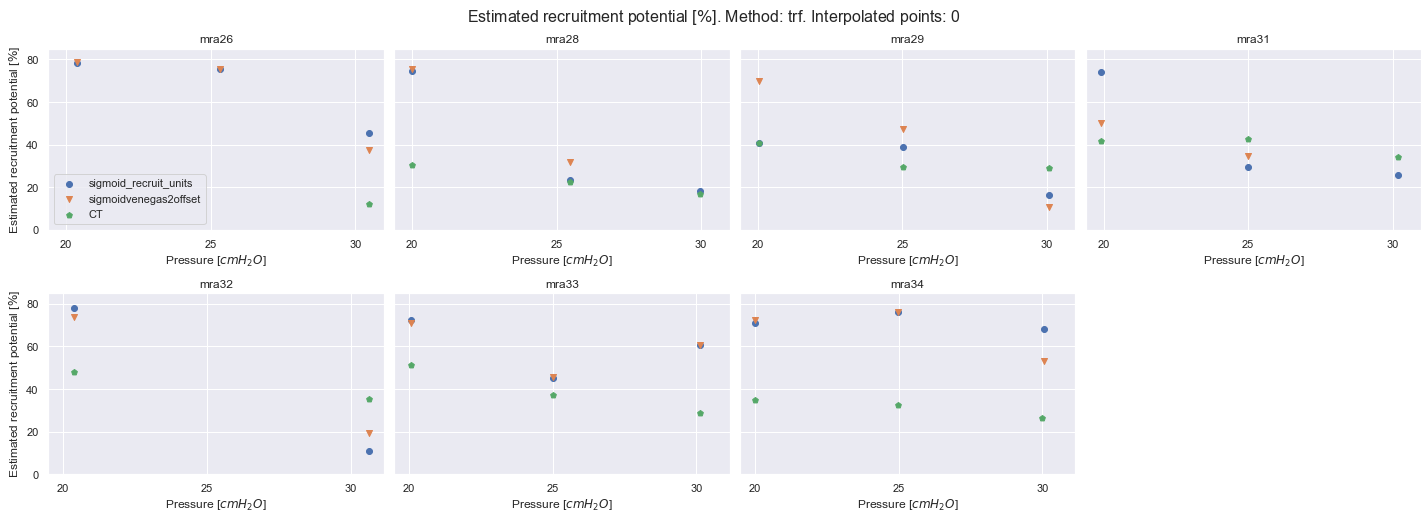

In [47]:
order = ('mra26','mra28','mra29','mra31','mra32','mra33','mra34')
models = ('sigmoid_recruit_units','sigmoidvenegas2offset')
met = 'trf'
markers = ('o','v','^','>','<','+','p')
n_interp = 0
fig, axs = plt.subplots(2,4,figsize=(20, 7),sharex='row',sharey='all')
for idx,animal in enumerate(order):
    for midx, model in enumerate(models):
        cond = (dados_ct_eit_fitted['Model'] == model)&\
               (dados_ct_eit_fitted['Animal'] == animal)&\
               (dados_ct_eit_fitted['Method'] == met)&\
               (dados_ct_eit_fitted['N_points_interp'] == n_interp)
        df = dados_ct_eit_fitted[cond]
        pressoes = df['Pmax'].values
        potencial_eit = df['RecPotential_eit'].values
        axs.ravel()[idx].scatter(pressoes,100.0*potencial_eit,label=f'{model}',marker=markers[midx])
    cond = (dados_ct_eit_fitted['Animal'] == animal)
    df = dados_ct_eit_fitted[cond]
    potencial_ct = df['Recruitment potential'].unique()
    pressoes = df['Pressure'].unique()
    axs.ravel()[idx].scatter(pressoes,100.0*potencial_ct,label=f'CT',marker=markers[-1])
    #axs.ravel()[idx].legend()
    axs.ravel()[idx].set_title(animal)
    axs.ravel()[idx].set_ylim(0,85)
    axs.ravel()[idx].set_xticks(np.arange(20,35,5))
    axs.ravel()[idx].set_xlabel('Pressure [$cmH_2O$]')
fig.delaxes(axs[1][3])
axs.ravel()[0].legend(loc='lower left')
axs.ravel()[0].set_ylabel('Estimated recruitment potential [$\%$]')
axs.ravel()[4].set_ylabel('Estimated recruitment potential [$\%$]')
fig.tight_layout()
plt.suptitle(f'Estimated recruitment potential [$\%$]. Method: {met}. Interpolated points: {n_interp}', fontsize=16, y=1.03)
plt.subplots_adjust(hspace=0.35, wspace=0.03)
plt.savefig(pasta_figuras_texto+f'recpot_compare_all_{met}.pdf',bbox_inches='tight')

In [55]:
if False: # já gravados... 20s
    for met in ('trf','lm','dogbox'):
        for n_interp in [0, 1, 2, 10, 20]:
            order = ('mra26','mra28','mra29','mra31','mra32','mra33','mra34')
            models = ('sigmoid_recruit_units','sigmoidvenegas2offset')
            markers = ('o','v','^','>','<','+','p')
            fig, axs = plt.subplots(2,4,figsize=(20, 7),sharex='row',sharey='all')
            for idx,animal in enumerate(order):
                for midx, model in enumerate(models):
                    cond = (dados_ct_eit_fitted['Model'] == model)&\
                           (dados_ct_eit_fitted['Animal'] == animal)&\
                           (dados_ct_eit_fitted['Method'] == met)&\
                           (dados_ct_eit_fitted['N_points_interp'] == n_interp)
                    df = dados_ct_eit_fitted[cond]
                    pressoes = df['Pmax'].values
                    potencial_eit = df['RecPotential_eit'].values
                    axs.ravel()[idx].scatter(pressoes,100.0*potencial_eit,label=f'{model}',marker=markers[midx])
                cond = (dados_ct_eit_fitted['Animal'] == animal)
                df = dados_ct_eit_fitted[cond]
                potencial_ct = df['Recruitment potential'].unique()
                pressoes = df['Pressure'].unique()
                axs.ravel()[idx].scatter(pressoes,100.0*potencial_ct,label=f'CT',marker=markers[-1])
                #axs.ravel()[idx].legend()
                axs.ravel()[idx].set_title(animal)
                axs.ravel()[idx].set_ylim(0,85)
                axs.ravel()[idx].set_xticks(np.arange(20,35,5))
                axs.ravel()[idx].set_xlabel('Pressure [$cmH_2O$]')
            fig.delaxes(axs[1][3])
            axs.ravel()[0].legend(loc='lower left')
            axs.ravel()[0].set_ylabel('Estimated recruitment potential [$\%$]')
            axs.ravel()[4].set_ylabel('Estimated recruitment potential [$\%$]')
            fig.tight_layout()
            plt.suptitle(f'Estimated recruitment potential [$\%$]. Method: {met}. Interpolated points: {n_interp}', fontsize=16, y=1.03)
            plt.subplots_adjust(hspace=0.35, wspace=0.03)
            plt.savefig(pasta_figuras_anexoC+f'recpot_compare_all_{met}_ninterp{n_interp}_Kestimado.pdf',bbox_inches='tight')
            plt.close(fig)

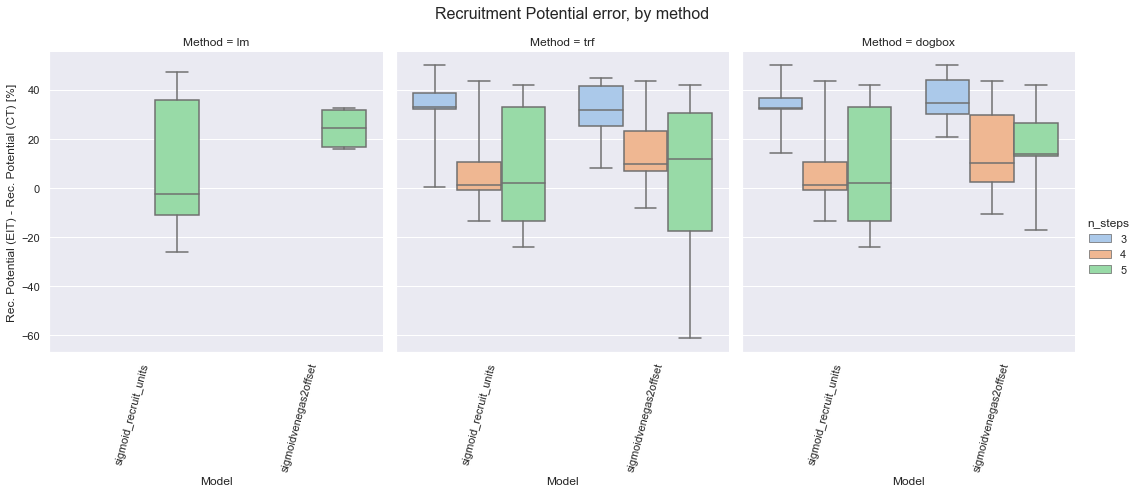

In [48]:
cond = (dados_ct_eit_fitted['Model']=='sigmoid_recruit_units')|(dados_ct_eit_fitted['Model']=='sigmoidvenegas2offset')
ax2 = sns.catplot(x="Model", y="RecPotential_error", kind="box", 
                  whis = 1000, col='Method', hue='n_steps', palette="pastel",
                  data=dados_ct_eit_fitted[cond])
ax2.set_xticklabels(rotation=75)
ax2.set_ylabels('Rec. Potential (EIT) - Rec. Potential (CT) [%]')#, fontsize=15) # 
plt.suptitle('Recruitment Potential error, by method', fontsize=16, y=1.05)
plt.savefig(pasta_figuras_texto+'recpot_error_by_method.pdf',bbox_inches='tight')
plt.show()

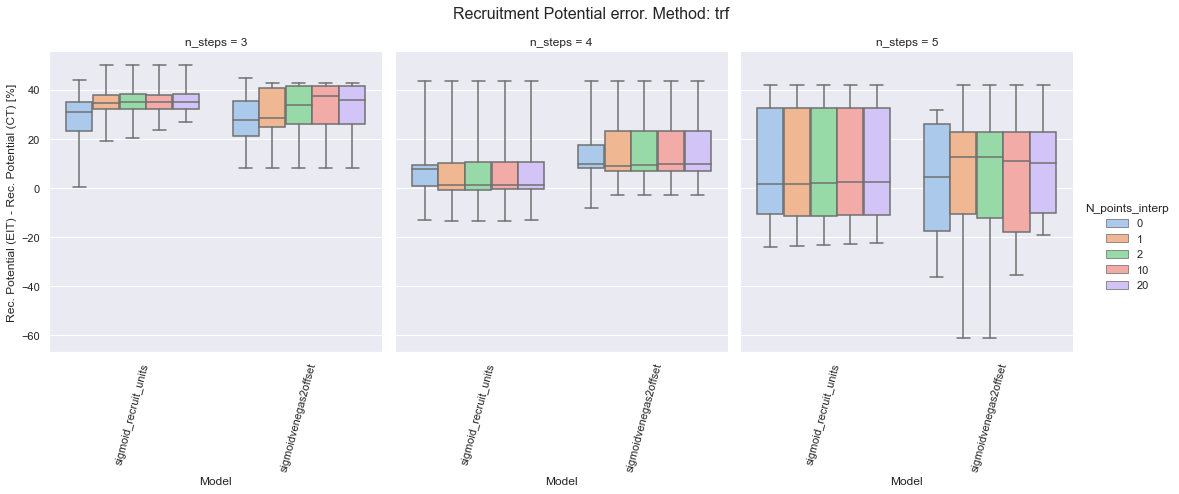

In [49]:
met = 'trf'
cond = ((dados_ct_eit_fitted['Model']=='sigmoid_recruit_units')|(dados_ct_eit_fitted['Model']=='sigmoidvenegas2offset'))&\
        (dados_ct_eit_fitted['Method']==met)
ax2 = sns.catplot(x="Model", y="RecPotential_error", kind="box", 
                  whis = 1000, col='n_steps', hue='N_points_interp', palette="pastel",
                  data=dados_ct_eit_fitted[cond])
ax2.set_xticklabels(rotation=75)
ax2.set_ylabels('Rec. Potential (EIT) - Rec. Potential (CT) [%]')#, fontsize=15) # 
plt.suptitle(f'Recruitment Potential error. Method: {met}', fontsize=16, y=1.05)
plt.savefig(pasta_figuras_texto+f'recpot_error_by_nsteps_ninterp_{met}.pdf',bbox_inches='tight')
plt.show()

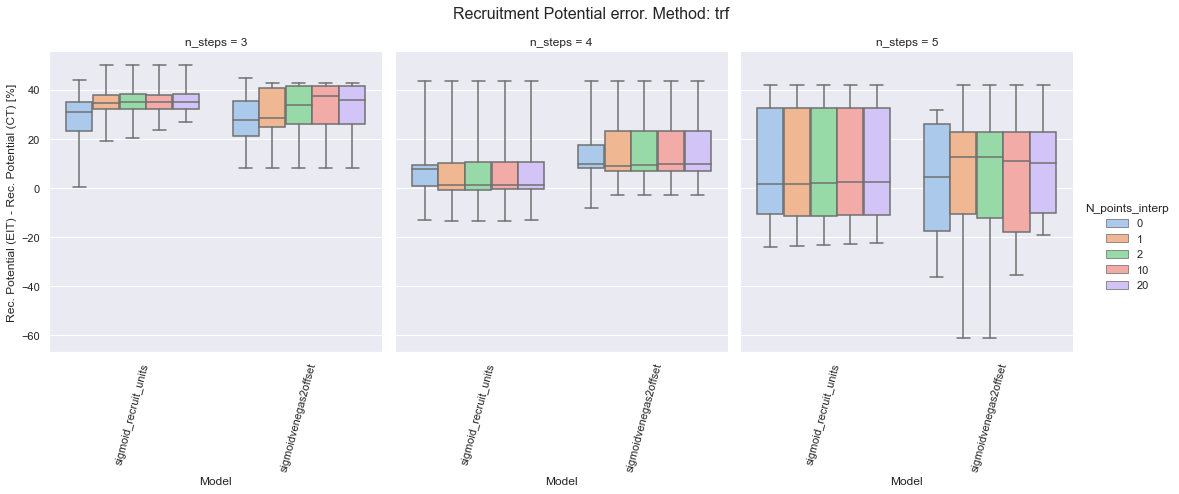

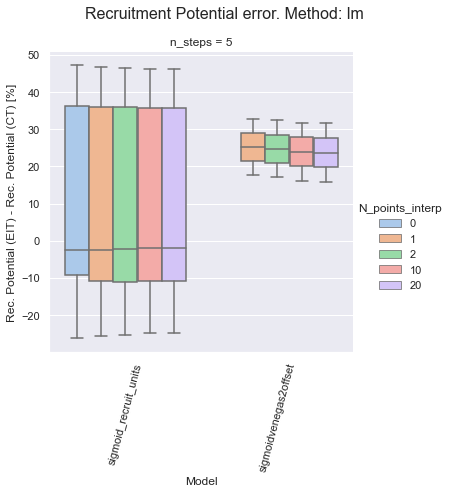

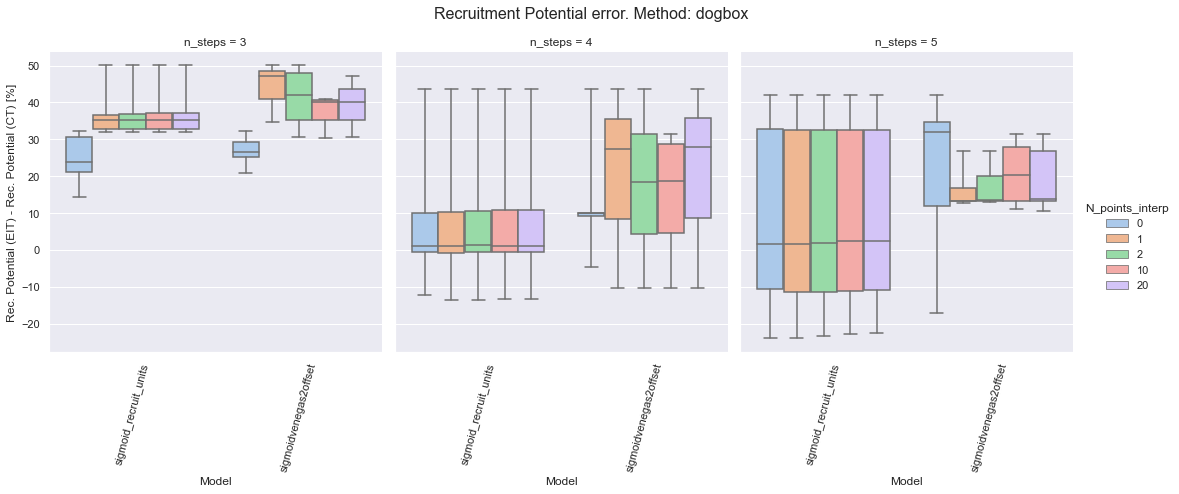

In [51]:
for met in ('trf','lm','dogbox'):
    cond = ((dados_ct_eit_fitted['Model']=='sigmoid_recruit_units')|(dados_ct_eit_fitted['Model']=='sigmoidvenegas2offset'))&\
            (dados_ct_eit_fitted['Method']==met)
    ax2 = sns.catplot(x="Model", y="RecPotential_error", kind="box", 
                      whis = 1000, col='n_steps', hue='N_points_interp', palette="pastel",
                      data=dados_ct_eit_fitted[cond])
    ax2.set_xticklabels(rotation=75)
    ax2.set_ylabels('Rec. Potential (EIT) - Rec. Potential (CT) [%]')#, fontsize=15) # 
    plt.suptitle(f'Recruitment Potential error. Method: {met}', fontsize=16, y=1.05)
    plt.savefig(pasta_figuras_anexoC+f'recpot_error_by_nsteps_ninterp_{met}_Kestimado.pdf',bbox_inches='tight')
    plt.show()

## K fixos

In [46]:
if False: # já gravados... 42s
    for met in ('trf','lm','dogbox'):
        for K1 in [0.03, 0.04, 0.05, 0.06, 0.07]:
            dados_ct_eit_fitted[['K1_eit','RecPotential_eit_K1','Recruited_eit_K1','RecPotential_error_K1' ]] = dados_ct_eit_fitted.apply(lambda x: estima_potencial(x, K=K1), axis=1, result_type='expand')
            cond = (dados_ct_eit_fitted['Method']==met)
            ax2 = sns.catplot(x="Model", y="RecPotential_error_K1", kind="box", 
                              whis = 1000, col='n_steps', hue='N_points_interp', palette="pastel",
                              data=dados_ct_eit_fitted[cond])
            ax2.set_xticklabels(rotation=75)
            ax2.set_ylabels('Rec. Potential (EIT) - Rec. Potential (CT) [%]')#, fontsize=15) # 
            plt.suptitle(f'Recruitment Potential error. Method: {met}. K = {K1}', fontsize=16, y=1.05)
            plt.savefig(pasta_figuras_anexoC+f'recpot_error_by_nsteps_ninterp_{met}_K{K1}.pdf',bbox_inches='tight')
            plt.close(plt.gcf())
            #plt.show()

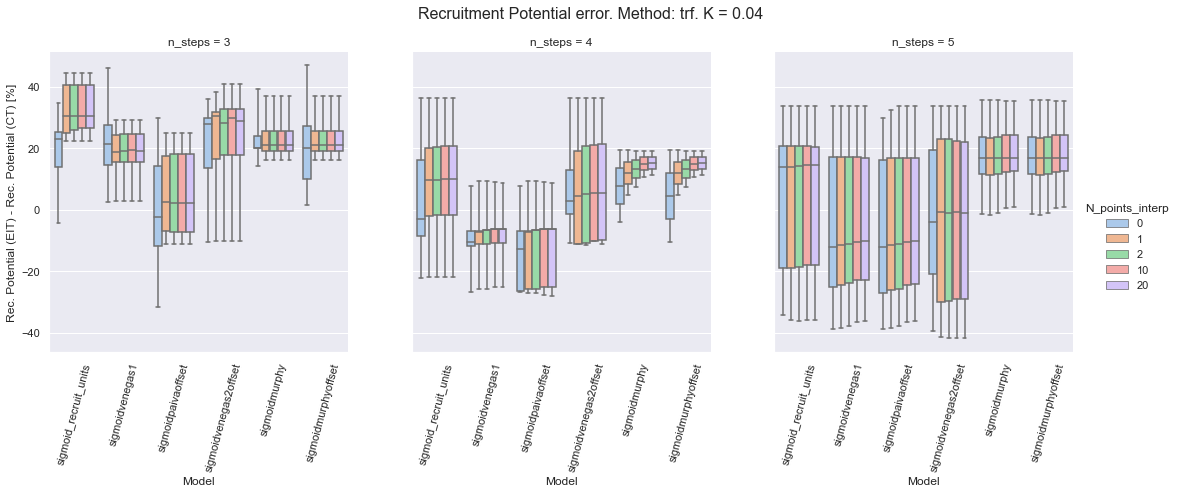

In [50]:
for K1 in [0.04]:
    dados_ct_eit_fitted[['K1_eit','RecPotential_eit_K1','Recruited_eit_K1','RecPotential_error_K1' ]] = dados_ct_eit_fitted.apply(lambda x: estima_potencial(x, K=K1), axis=1, result_type='expand')
    met = 'trf'
    cond = (dados_ct_eit_fitted['Method']==met)
    ax2 = sns.catplot(x="Model", y="RecPotential_error_K1", kind="box", 
                      whis = 1000, col='n_steps', hue='N_points_interp', palette="pastel",
                      data=dados_ct_eit_fitted[cond])
    ax2.set_xticklabels(rotation=75)
    ax2.set_ylabels('Rec. Potential (EIT) - Rec. Potential (CT) [%]')#, fontsize=15) # 
    plt.suptitle(f'Recruitment Potential error. Method: {met}. K = {K1}', fontsize=16, y=1.05)
    plt.savefig(pasta_figuras_texto+f'recpot_error_by_nsteps_ninterp_{met}_K{K1}.pdf',bbox_inches='tight')
    plt.show()

## Bland-Altman

### K estimado

In [58]:
dados_ct_eit_fitted.iloc[0]

Animal                                                               mra31
Pressure                                                              30.2
PEEPs                                                                   30
Recruited percentage                                              0.656071
Recruitment potential                                             0.343929
Maneuver                                                                 D
n_steps                                                                  5
Pressures                [10.0, 15.0, 20.100000381469727, 24.8999996185...
Volumes                  [-107.7169418334961, 47.35507583618164, 235.19...
Model                                                sigmoid_recruit_units
Method                                                                  lm
TLC_index                                                                1
TLC_eit                                                        1017.468717
N_points_interp          

In [85]:
model_lst = ('sigmoid_recruit_units','sigmoidvenegas1','sigmoidpaivaoffset','sigmoidvenegas2offset','sigmoidmurphy','sigmoidmurphyoffset')
model_lst_estimatedK = ('sigmoid_recruit_units','sigmoidvenegas2offset')
met_lst = ('trf','dogbox','lm')
ninterp_lst = [0, 1, 2, 10, 20]
manobra_lst = ('B','C','D')

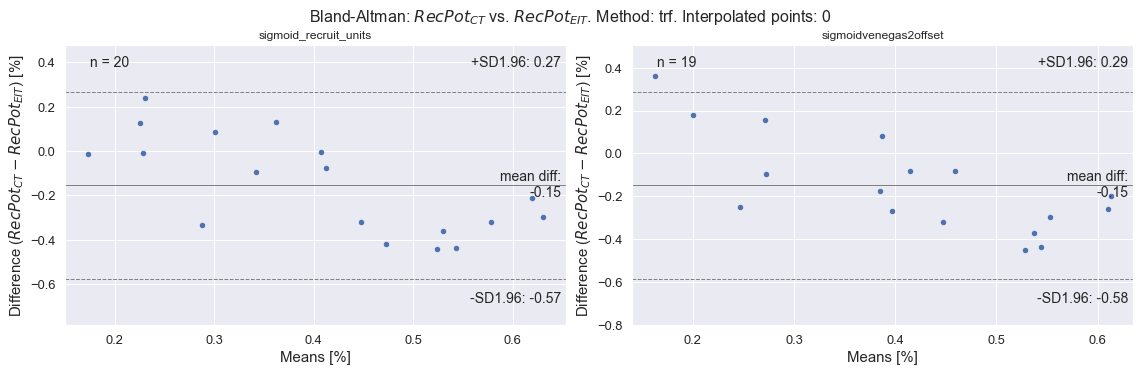

In [138]:
f, ax = plt.subplots(1,2, figsize = (16,5))
met = 'trf'
ninterp = 0
for idx,model in enumerate(model_lst_estimatedK):
    cond = (dados_ct_eit_fitted['Model']==model)&\
           (dados_ct_eit_fitted['N_points_interp']==ninterp)&\
           (dados_ct_eit_fitted['fitted']==True)&\
           (dados_ct_eit_fitted['Method']==met)&\
           ((dados_ct_eit_fitted['Model']=='sigmoid_recruit_units')|(dados_ct_eit_fitted['Model']=='sigmoidvenegas2offset'))
    if len(dados_ct_eit_fitted[cond]) > 0:
        #print(model)
        #print(dados_ct_eit_fitted[cond]['Recruitment potential'].values)
        #print(dados_ct_eit_fitted[cond]['RecPotential_eit'])
        #print(f'{len(dados_ct_eit_fitted[cond]['Recruitment potential'])} {len(dados_ct_eit_fitted[cond]['RecPotential_eit'])}')
        sm.graphics.mean_diff_plot(dados_ct_eit_fitted[cond]['Recruitment potential'],dados_ct_eit_fitted[cond]['RecPotential_eit'], ax = ax.ravel()[idx])
        ax.ravel()[idx].set_title(model)
        ax.ravel()[idx].set_xlabel('Means [%]')
        ax.ravel()[idx].set_ylabel('Difference ($RecPot_{CT} - RecPot_{EIT}$) [%]')
        xmin,xmax = ax.ravel()[idx].get_xlim()
        ymin,ymax = ax.ravel()[idx].get_ylim()
        ax.ravel()[idx].text(xmin+0.05*(xmax-xmin),ymin+0.92*(ymax-ymin),f'n = {len(dados_ct_eit_fitted[cond])}', fontsize=14)
    
plt.suptitle('Bland-Altman: $RecPot_{CT}$ vs. $RecPot_{EIT}$. Method: ' + met + f'. Interpolated points: {ninterp}', fontsize=16, y=1.03)
plt.savefig(pasta_figuras_texto+f'BlandAltman_recpot_niterp{ninterp}_{met}_Kestimado.pdf',bbox_inches='tight')
plt.show()

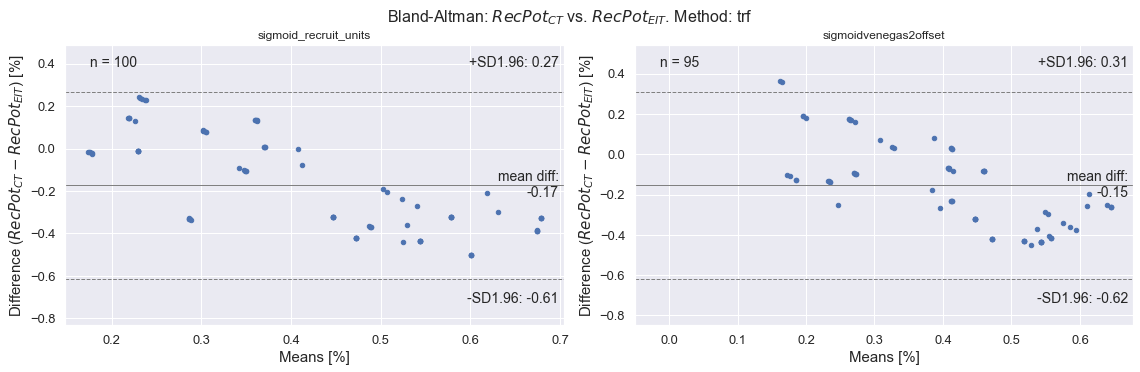

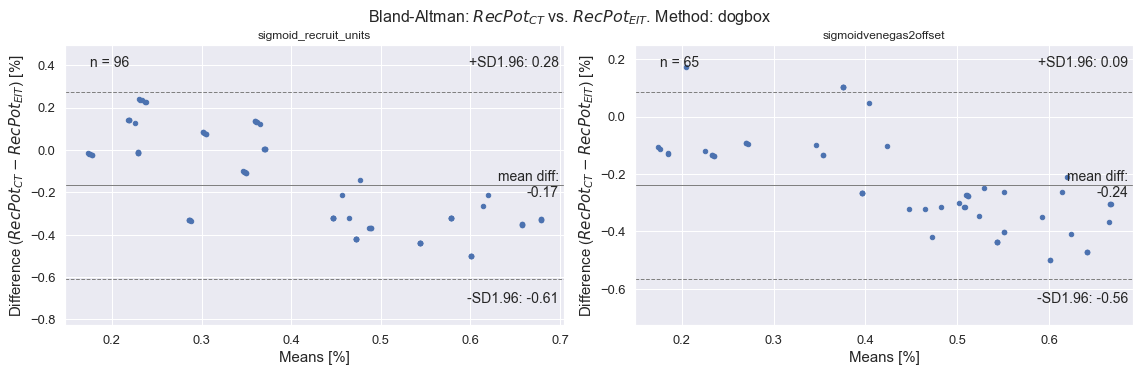

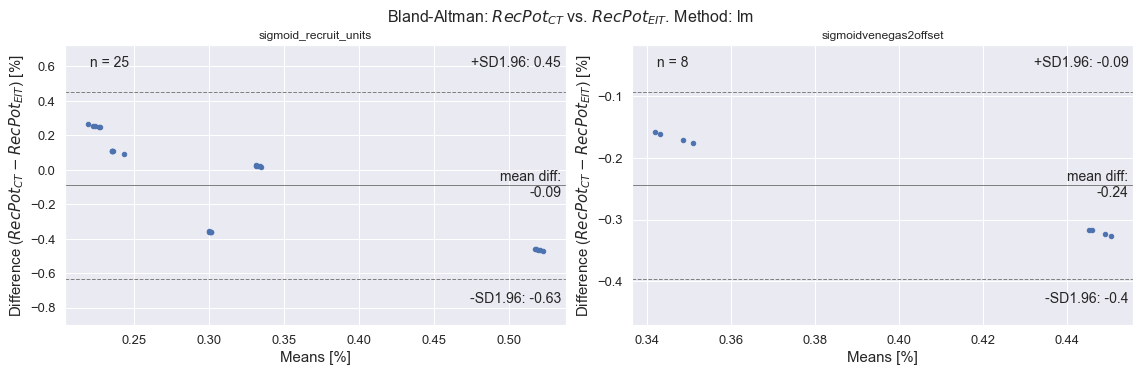

In [150]:
for met in met_lst:
    f, ax = plt.subplots(1,2, figsize = (16,5))
    for idx,model in enumerate(model_lst_estimatedK):
        cond = (dados_ct_eit_fitted['Model']==model)&\
               (dados_ct_eit_fitted['fitted']==True)&\
               (dados_ct_eit_fitted['Method']==met)&\
               ((dados_ct_eit_fitted['Model']=='sigmoid_recruit_units')|(dados_ct_eit_fitted['Model']=='sigmoidvenegas2offset'))
        if len(dados_ct_eit_fitted[cond]) > 0:
            #print(model)
            #print(dados_ct_eit_fitted[cond]['Recruitment potential'].values)
            #print(dados_ct_eit_fitted[cond]['RecPotential_eit'])
            #print(f'{len(dados_ct_eit_fitted[cond]['Recruitment potential'])} {len(dados_ct_eit_fitted[cond]['RecPotential_eit'])}')
            sm.graphics.mean_diff_plot(dados_ct_eit_fitted[cond]['Recruitment potential'],dados_ct_eit_fitted[cond]['RecPotential_eit'], ax = ax.ravel()[idx])
            ax.ravel()[idx].set_title(model)
            ax.ravel()[idx].set_xlabel('Means [%]')
            ax.ravel()[idx].set_ylabel('Difference ($RecPot_{CT} - RecPot_{EIT}$) [%]')
            xmin,xmax = ax.ravel()[idx].get_xlim()
            ymin,ymax = ax.ravel()[idx].get_ylim()
            ax.ravel()[idx].text(xmin+0.05*(xmax-xmin),ymin+0.92*(ymax-ymin),f'n = {len(dados_ct_eit_fitted[cond])}', fontsize=14)

    plt.suptitle('Bland-Altman: $RecPot_{CT}$ vs. $RecPot_{EIT}$. Method: ' + met, fontsize=16, y=1.03)
    plt.savefig(pasta_figuras_anexoE+f'BlandAltman_recpot_{met}_Kestimado.pdf',bbox_inches='tight')
    plt.show()

#### Teste regressão

In [135]:
def linear(x,a,b):
    return a*x + b

def parab(x,a,b,c):
    return a*x*x + b*x + c

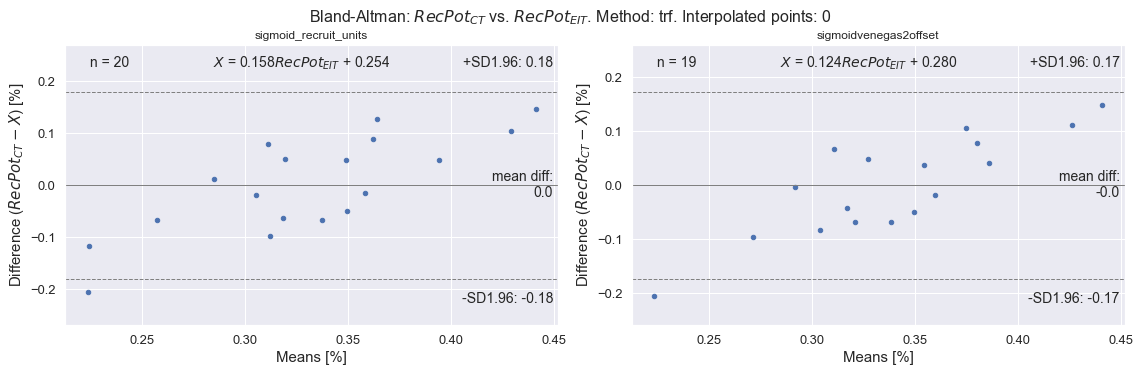

In [144]:
f, ax = plt.subplots(1,2, figsize = (16,5))
met = 'trf'
ninterp = 0
for idx,model in enumerate(model_lst_estimatedK):
    cond = (dados_ct_eit_fitted['Model']==model)&\
           (dados_ct_eit_fitted['N_points_interp']==ninterp)&\
           (dados_ct_eit_fitted['fitted']==True)&\
           (dados_ct_eit_fitted['Method']==met)&\
           ((dados_ct_eit_fitted['Model']=='sigmoid_recruit_units')|(dados_ct_eit_fitted['Model']=='sigmoidvenegas2offset'))
    if len(dados_ct_eit_fitted[cond]) > 0:
        valid = np.isfinite(np.array(dados_ct_eit_fitted[cond]['Recruitment potential'].values,dtype=float))
        param,pcov = curve_fit(linear,dados_ct_eit_fitted[cond]['RecPotential_eit'][valid],dados_ct_eit_fitted[cond]['Recruitment potential'].values[valid],p0=[0.25,0.19],method='trf')
        sm.graphics.mean_diff_plot(dados_ct_eit_fitted[cond]['Recruitment potential'],(param[0]*dados_ct_eit_fitted[cond]['RecPotential_eit']+param[1]), ax = ax.ravel()[idx])
        ax.ravel()[idx].set_title(model)
        ax.ravel()[idx].set_xlabel('Means [%]')
        ax.ravel()[idx].set_ylabel('Difference ($RecPot_{CT} - X$) [%]')
        xmin,xmax = ax.ravel()[idx].get_xlim()
        ymin,ymax = ax.ravel()[idx].get_ylim()
        ax.ravel()[idx].text(xmin+0.05*(xmax-xmin),ymin+0.92*(ymax-ymin),f'n = {len(dados_ct_eit_fitted[cond])}', fontsize=14)
        ax.ravel()[idx].text(xmin+0.3*(xmax-xmin),ymin+0.92*(ymax-ymin),'$X$ = ' + f'{param[0]:.3f}'+'$RecPot_{EIT}$'+f' + {param[1]:.3f}', fontsize=14)
    
plt.suptitle('Bland-Altman: $RecPot_{CT}$ vs. $RecPot_{EIT}$. Method: ' + met + f'. Interpolated points: {ninterp}', fontsize=16, y=1.03)
plt.savefig(pasta_figuras_texto+f'BlandAltman_recpot_niterp{ninterp}_{met}_Kestimado_regressao.pdf',bbox_inches='tight')
plt.show()

### K fixo

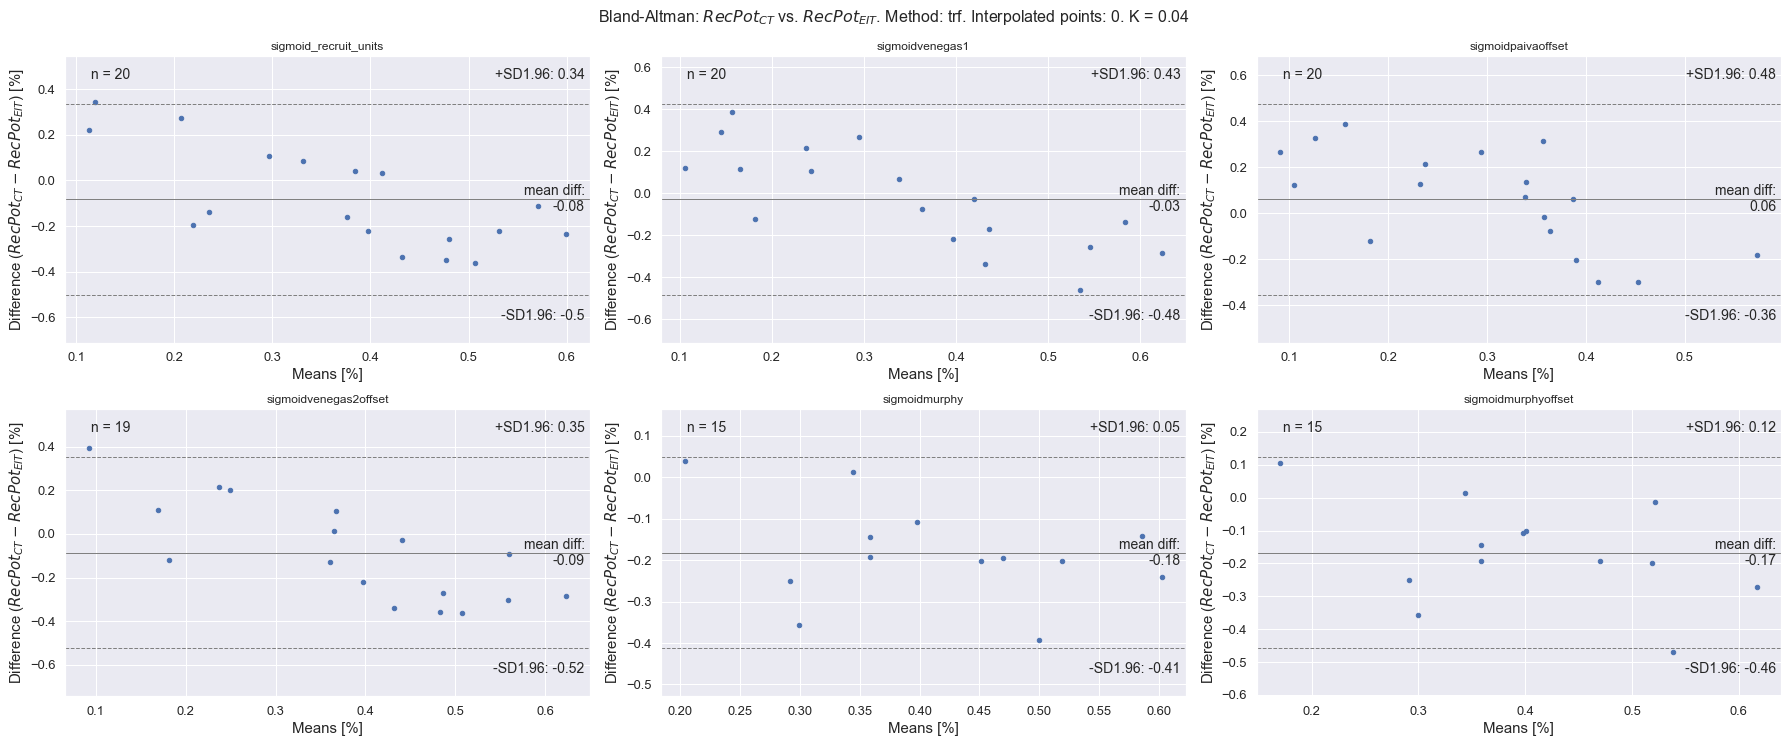

In [142]:
f, ax = plt.subplots(2,3, figsize = (25,10))
met = 'trf'
ninterp = 0
K1 = 0.04
dados_ct_eit_fitted[['K1_eit','RecPotential_eit_K1','Recruited_eit_K1','RecPotential_error_K1' ]] = dados_ct_eit_fitted.apply(lambda x: estima_potencial(x, K=K1), axis=1, result_type='expand')
for idx,model in enumerate(model_lst):
    cond = (dados_ct_eit_fitted['Model']==model)&\
           (dados_ct_eit_fitted['N_points_interp']==ninterp)&\
           (dados_ct_eit_fitted['fitted']==True)&\
           (dados_ct_eit_fitted['Method']==met)
    if len(dados_ct_eit_fitted[cond]) > 0:
        #print(model)
        #print(dados_ct_eit_fitted[cond]['Recruitment potential'].values)
        #print(dados_ct_eit_fitted[cond]['RecPotential_eit'])
        #print(f'{len(dados_ct_eit_fitted[cond]['Recruitment potential'])} {len(dados_ct_eit_fitted[cond]['RecPotential_eit'])}')
        sm.graphics.mean_diff_plot(dados_ct_eit_fitted[cond]['Recruitment potential'],dados_ct_eit_fitted[cond]['RecPotential_eit_K1'], ax = ax.ravel()[idx])
        ax.ravel()[idx].set_title(model)
        ax.ravel()[idx].set_xlabel('Means [%]')
        ax.ravel()[idx].set_ylabel('Difference ($RecPot_{CT} - RecPot_{EIT}$) [%]')
        xmin,xmax = ax.ravel()[idx].get_xlim()
        ymin,ymax = ax.ravel()[idx].get_ylim()
        ax.ravel()[idx].text(xmin+0.05*(xmax-xmin),ymin+0.92*(ymax-ymin),f'n = {len(dados_ct_eit_fitted[cond])}', fontsize=14)
    
plt.suptitle('Bland-Altman: $RecPot_{CT}$ vs. $RecPot_{EIT}$. Method: ' + met + f'. Interpolated points: {ninterp}. K = {K1}', fontsize=16, y=1.03)
plt.savefig(pasta_figuras_texto+f'BlandAltman_recpot_niterp{ninterp}_{met}_K{K1}.pdf',bbox_inches='tight')
plt.show()


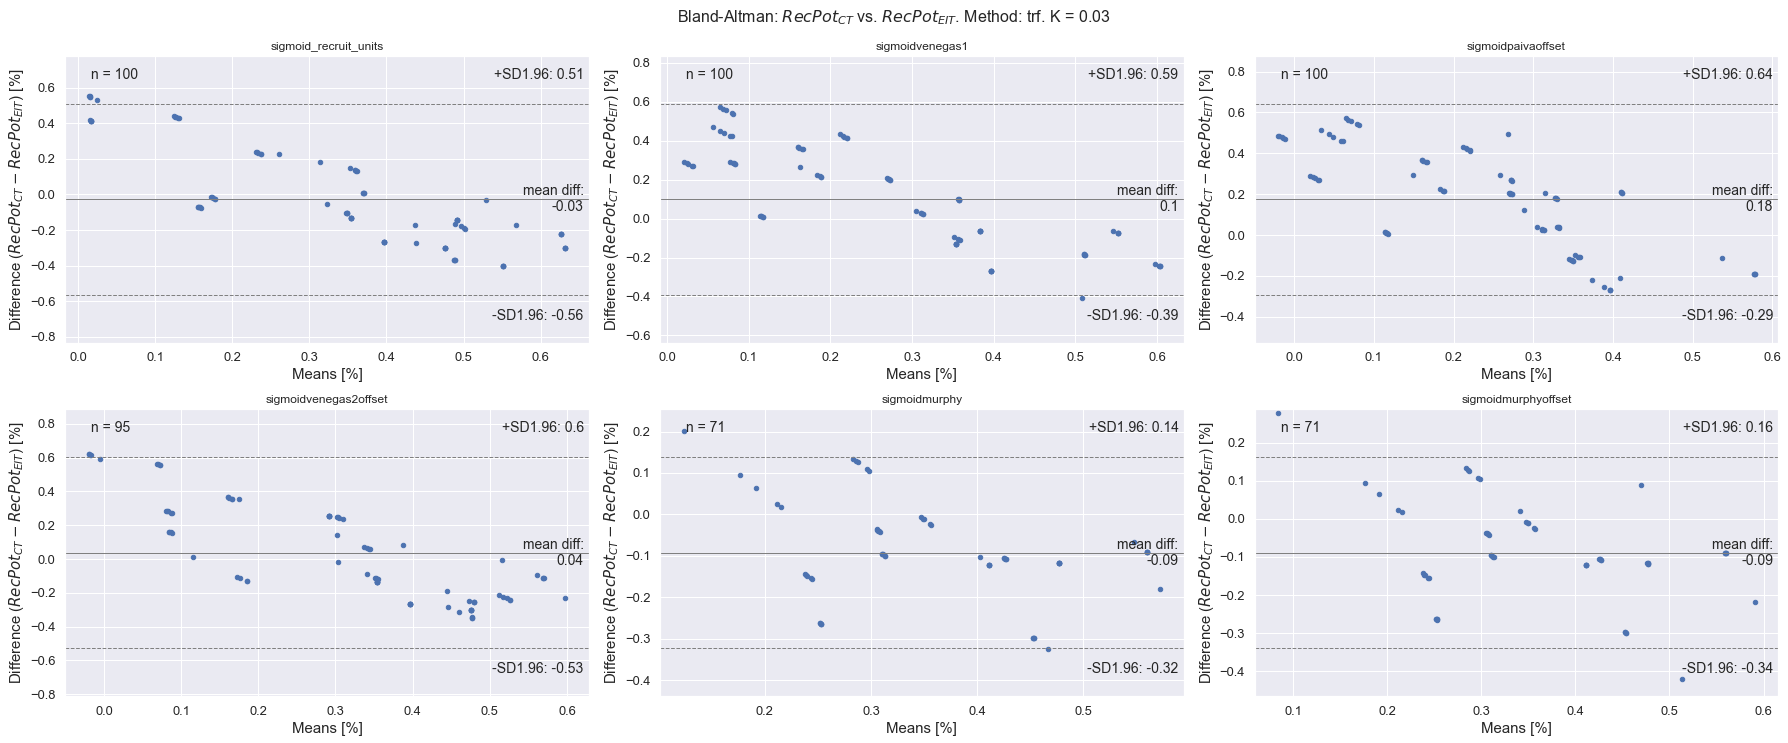

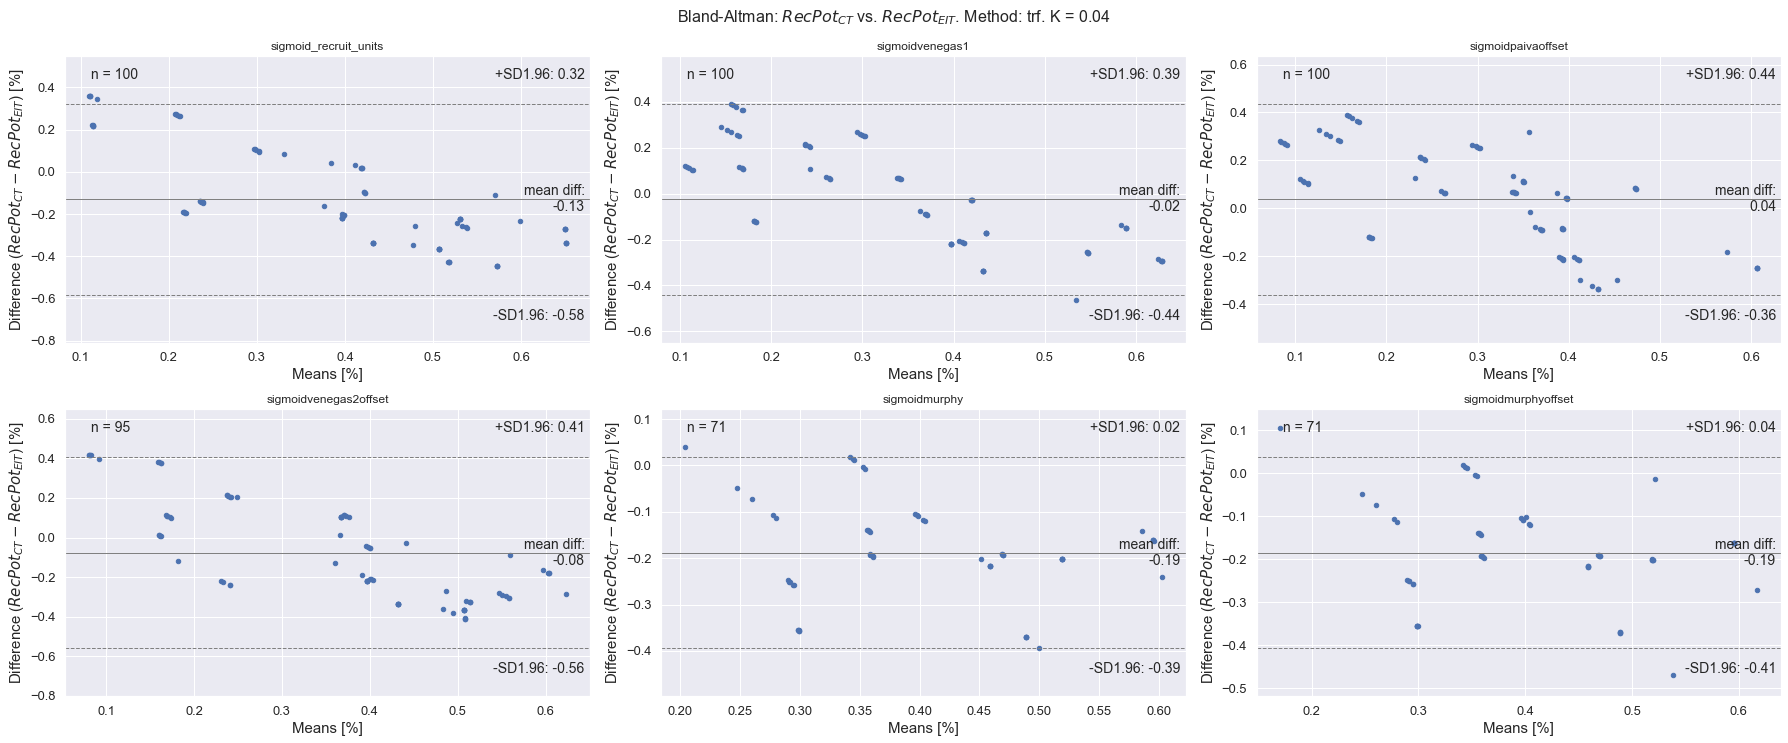

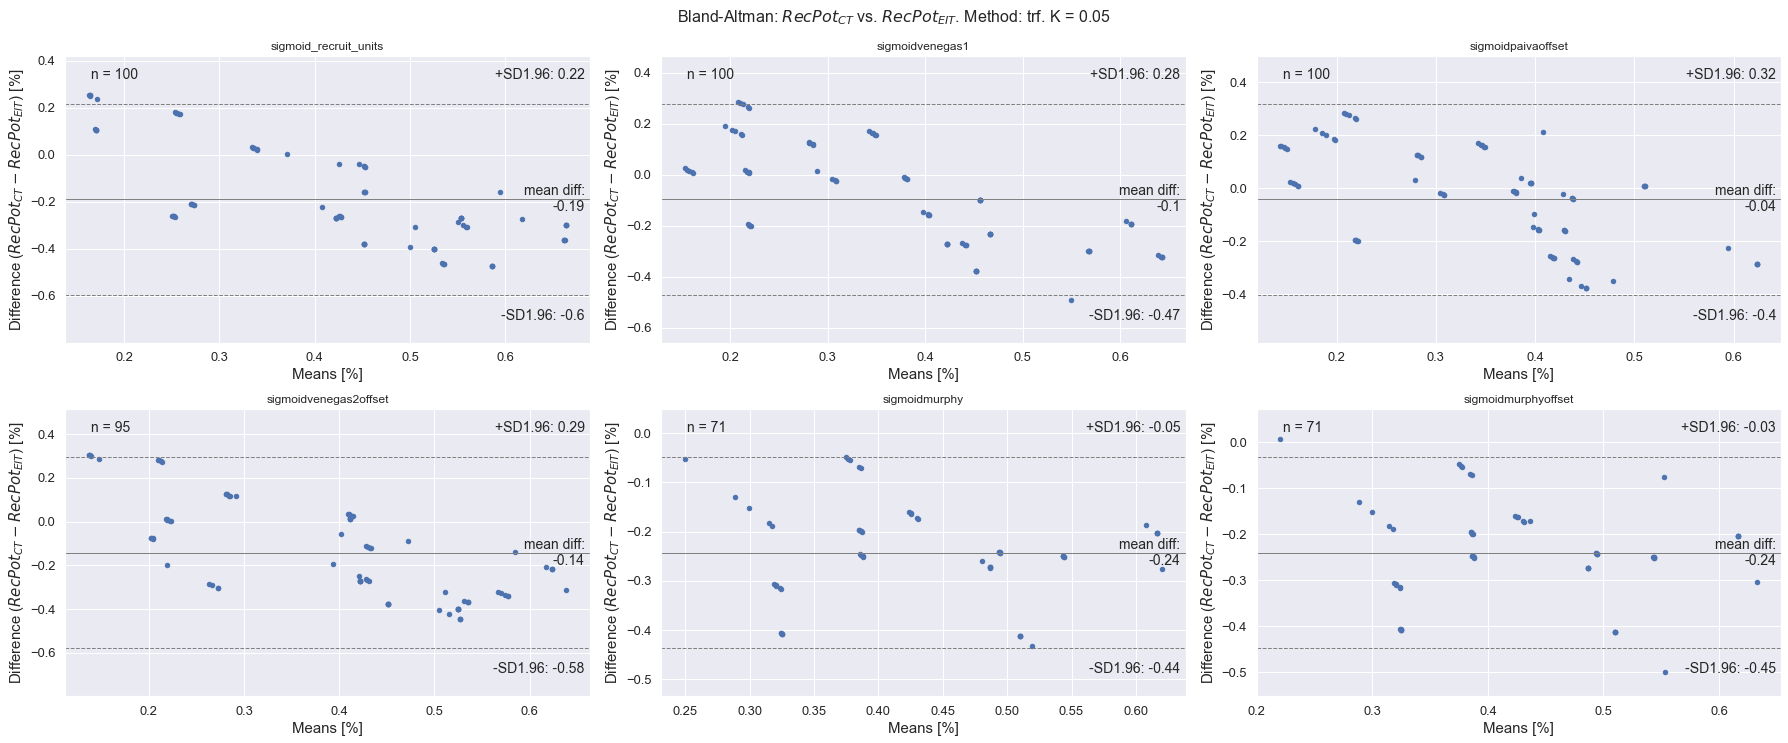

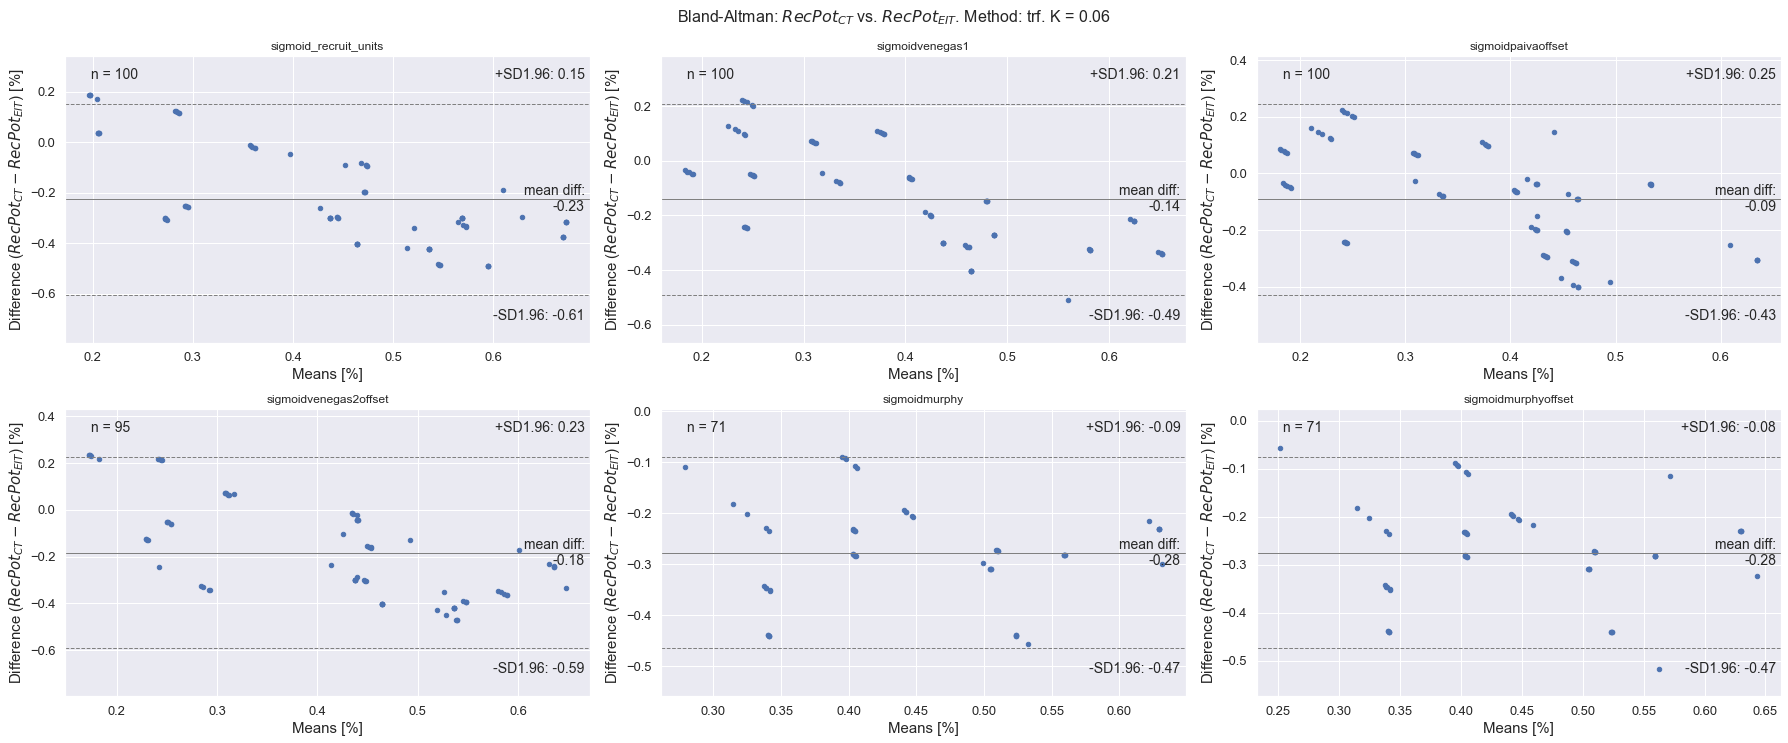

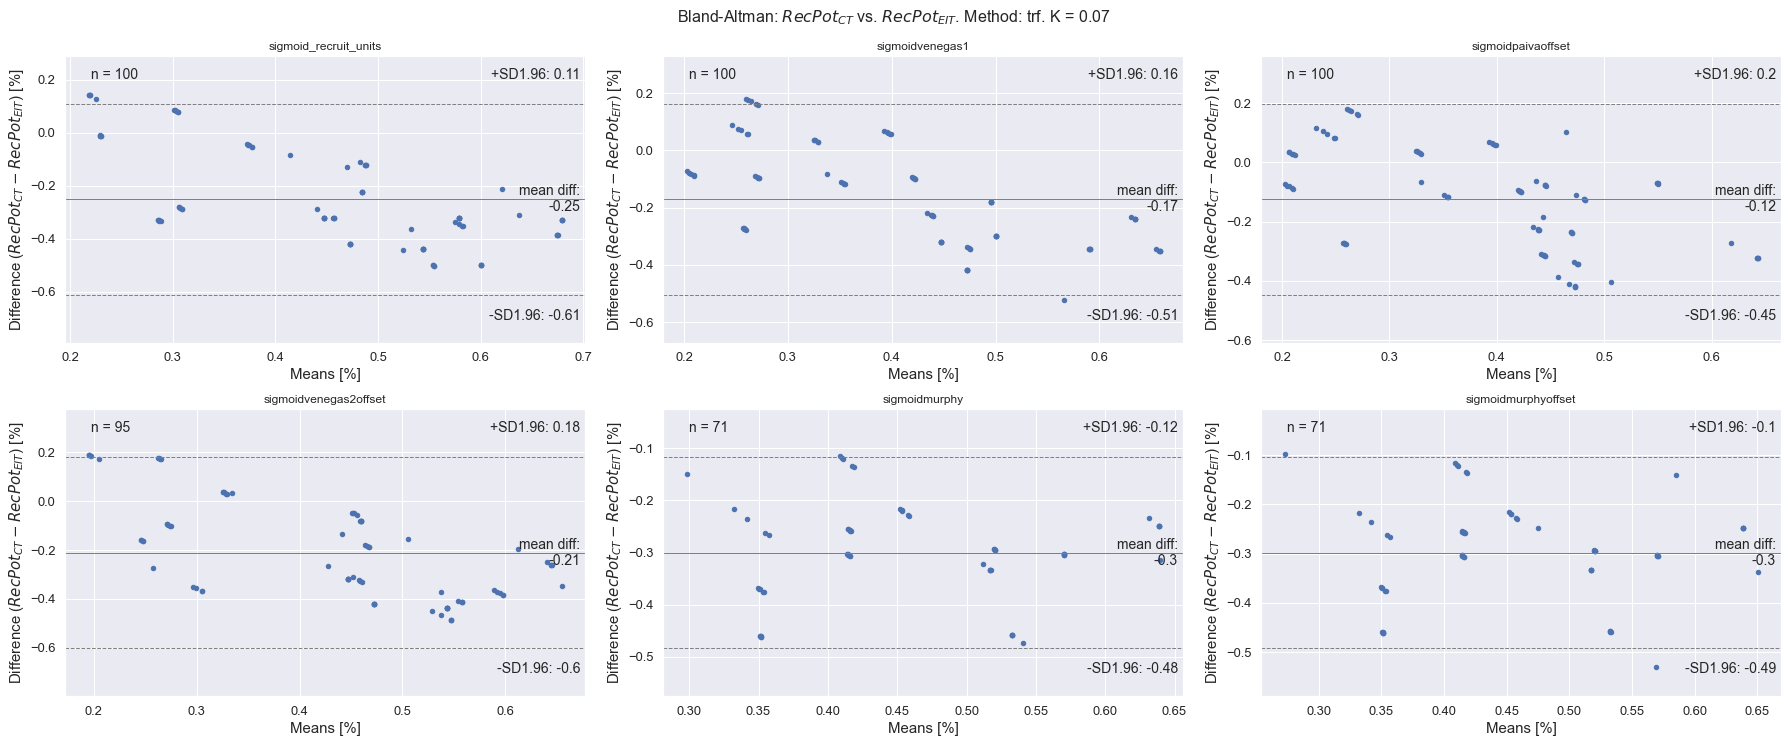

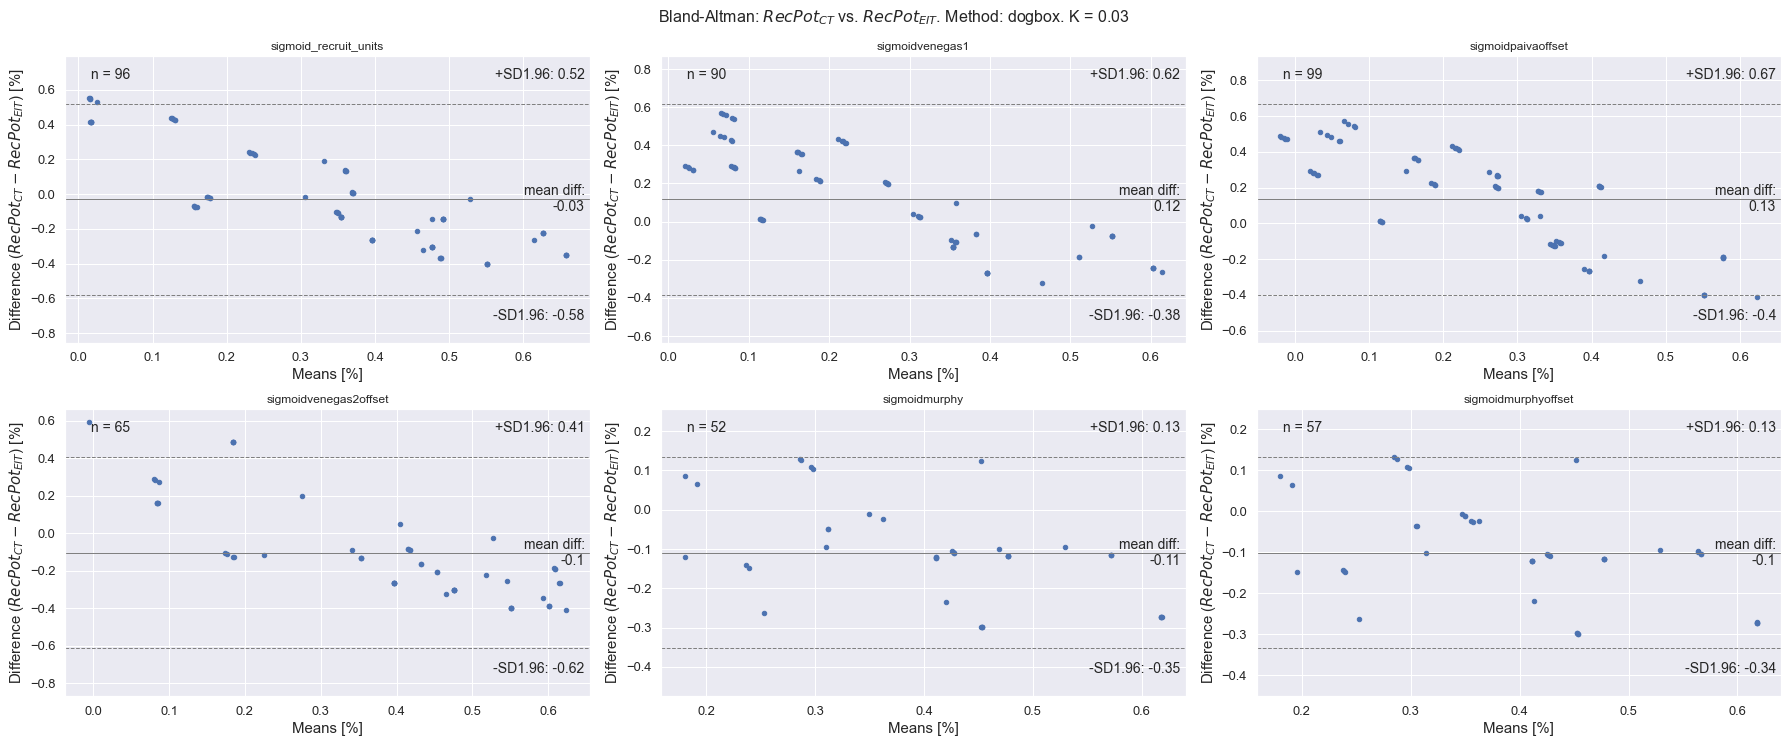

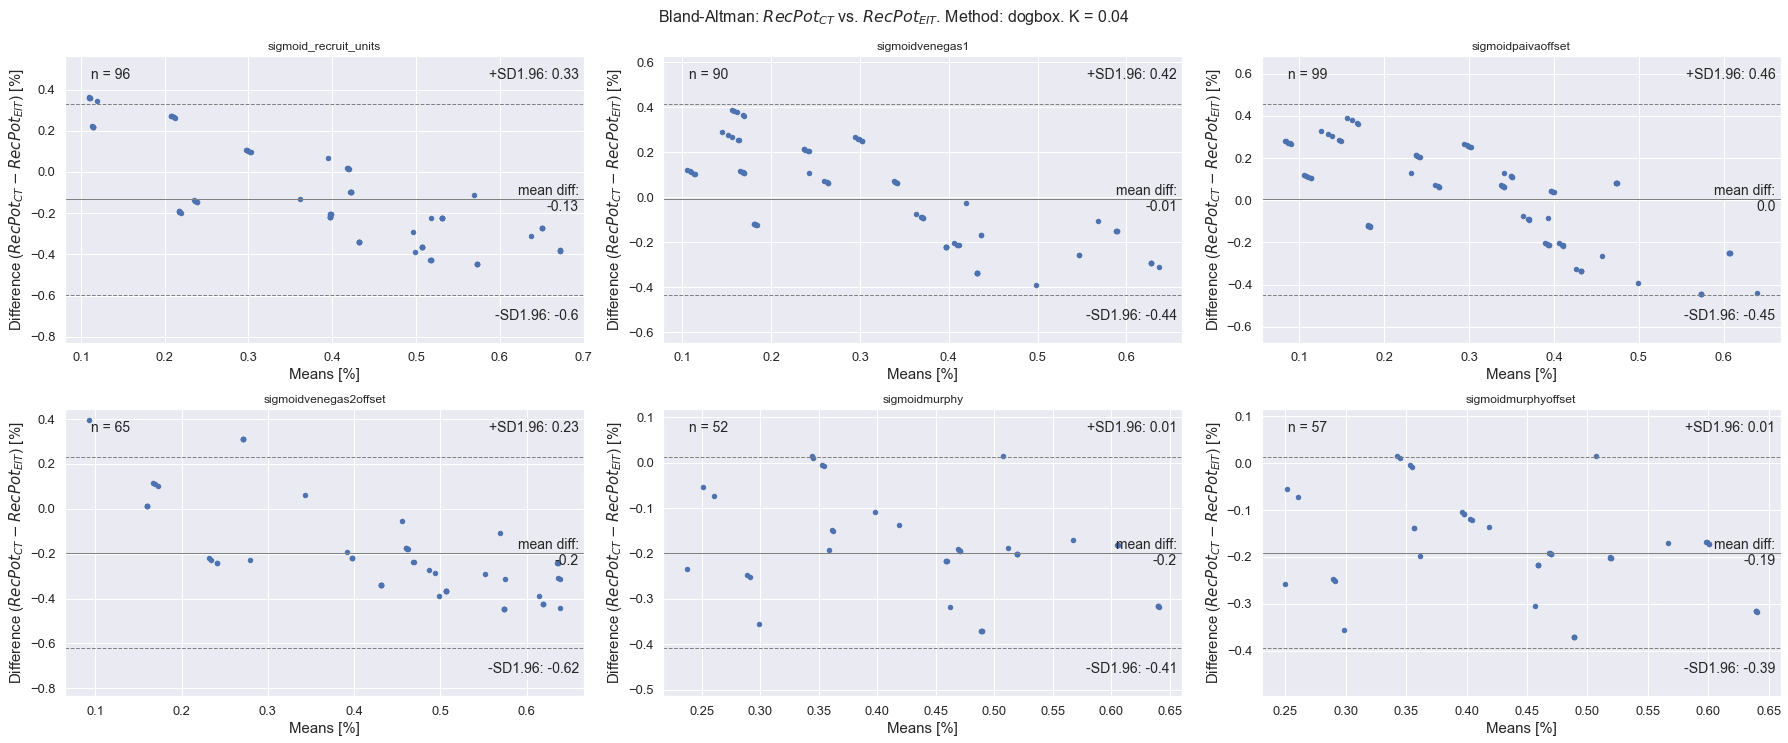

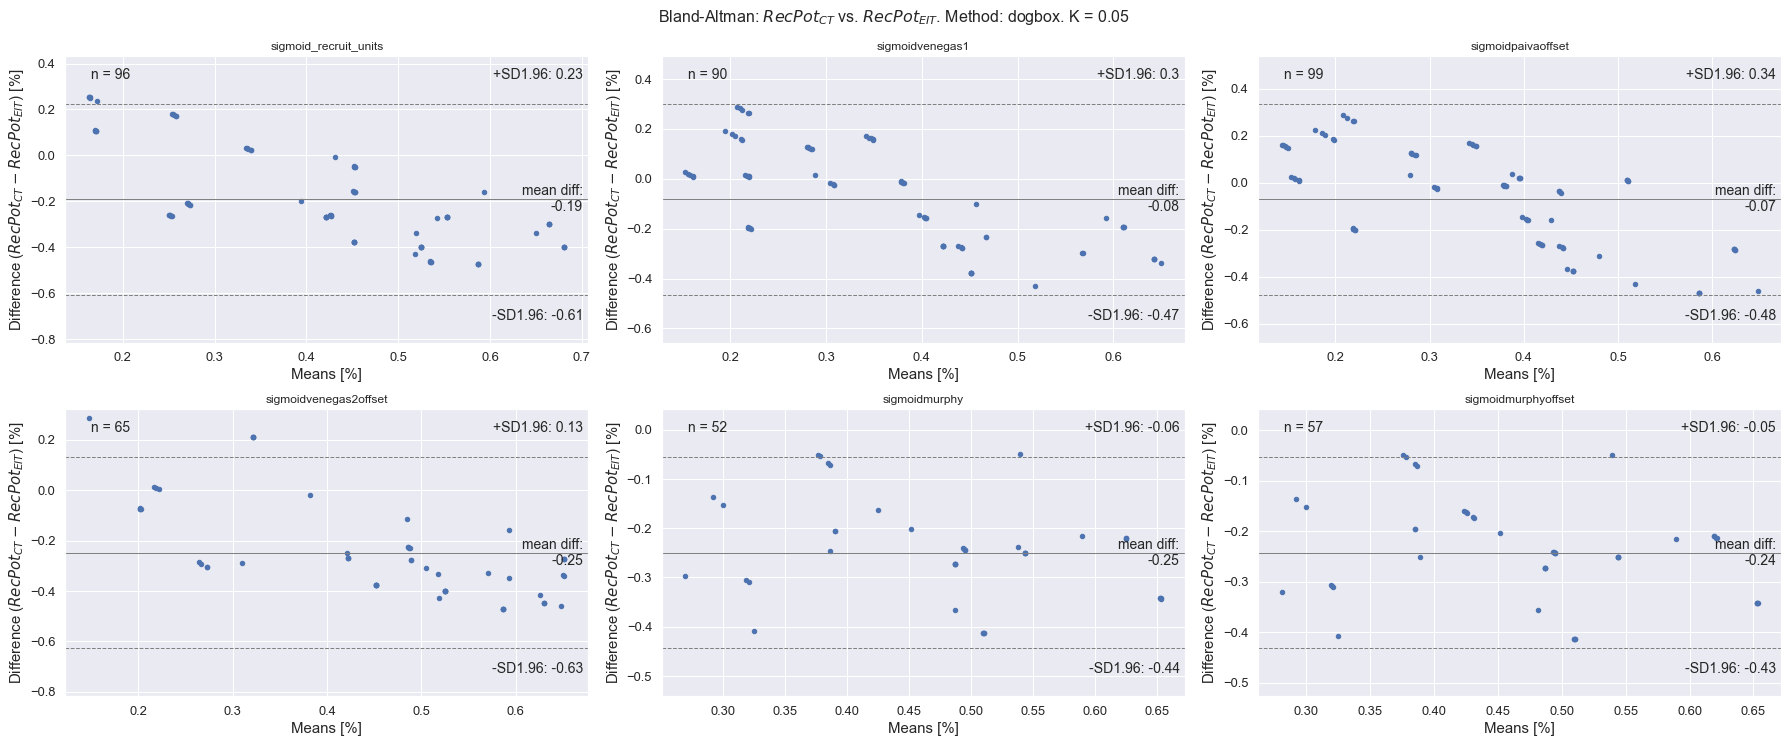

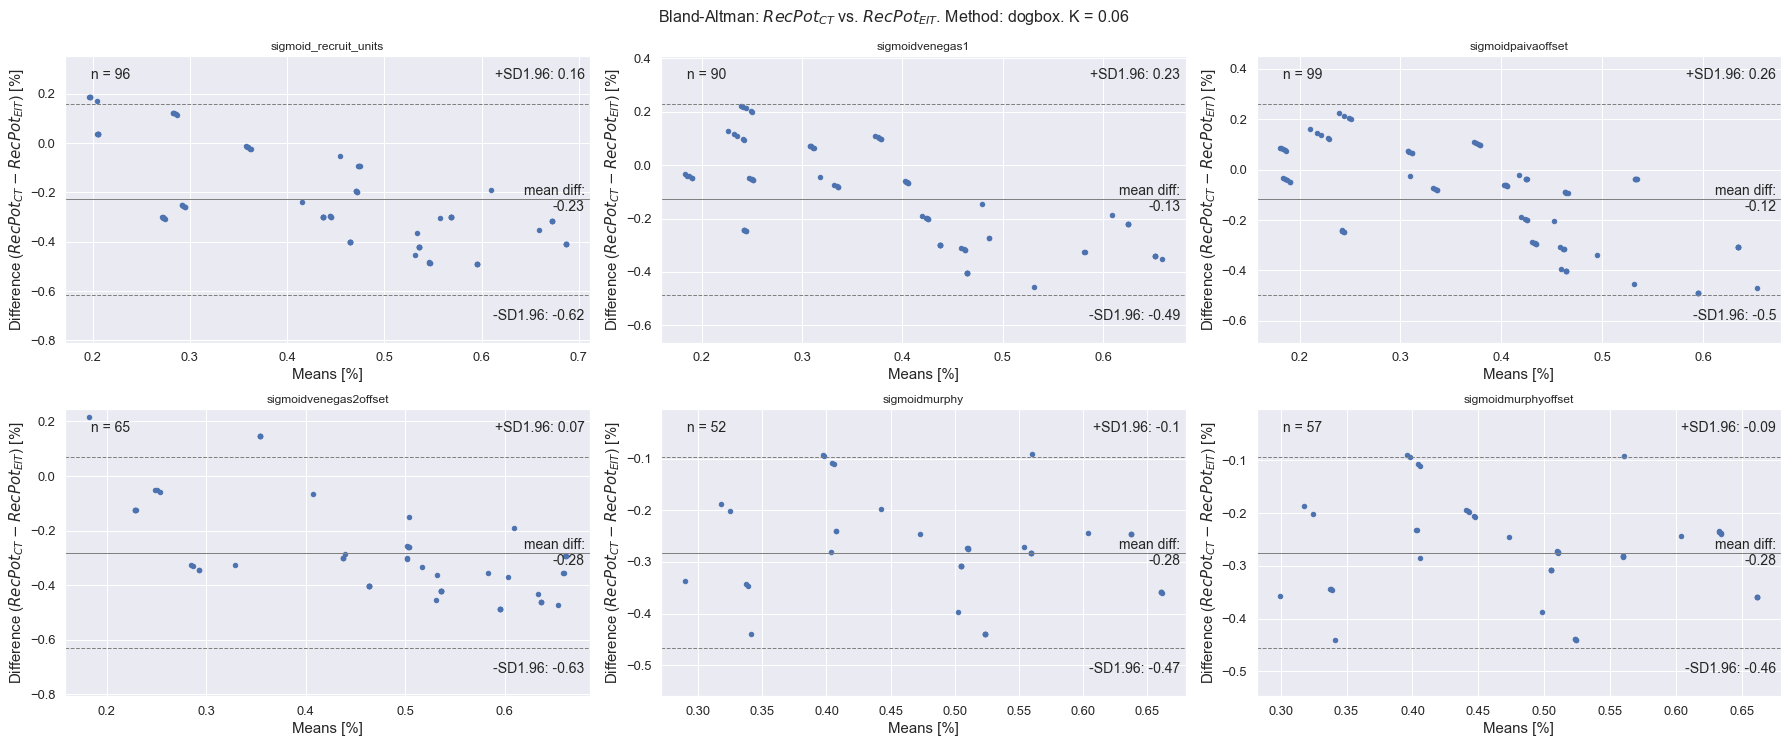

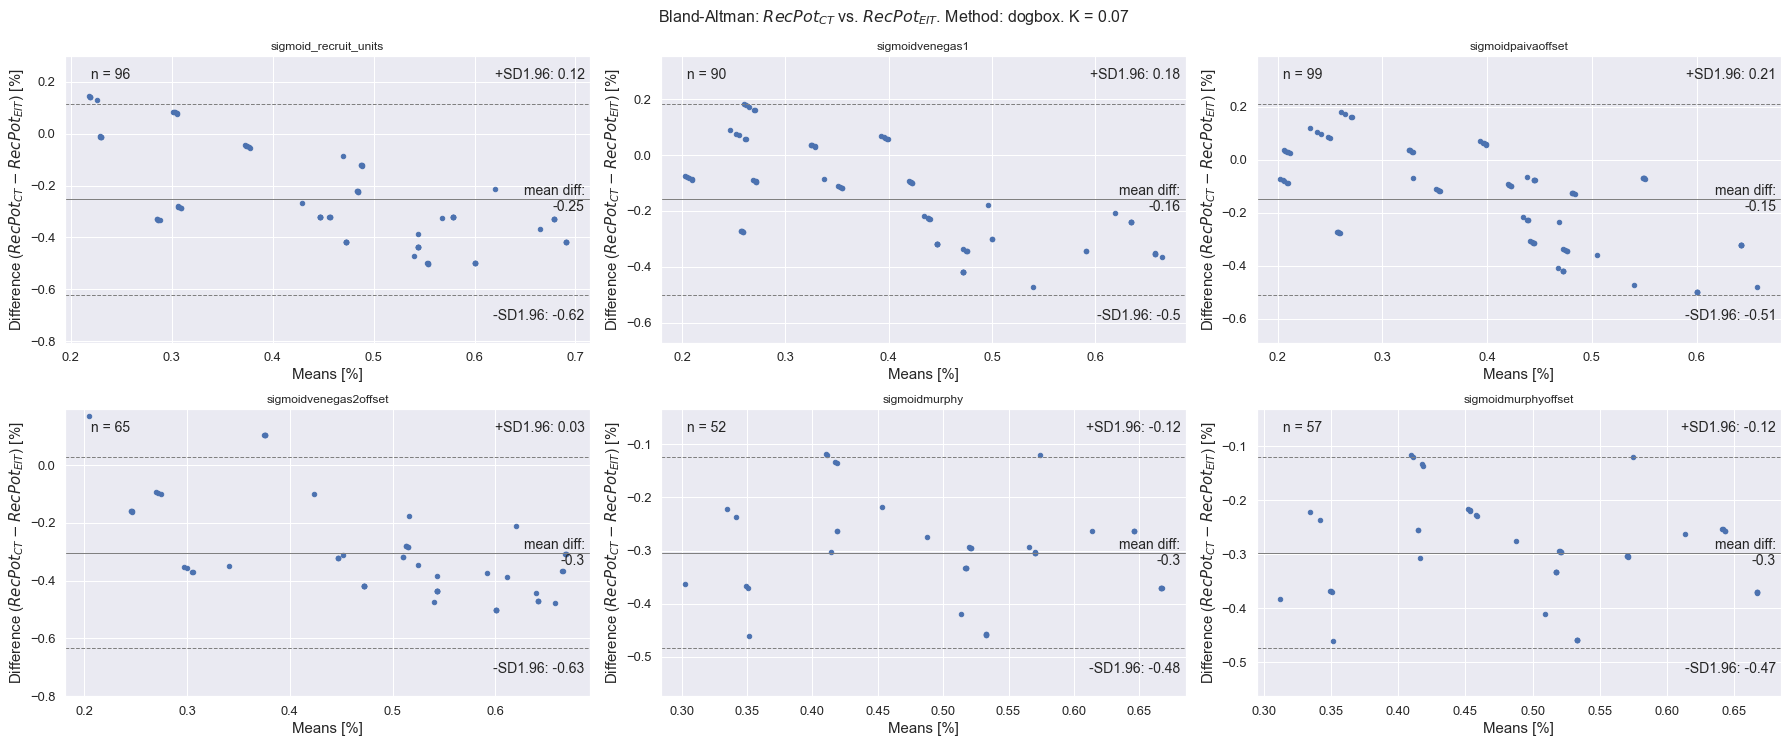

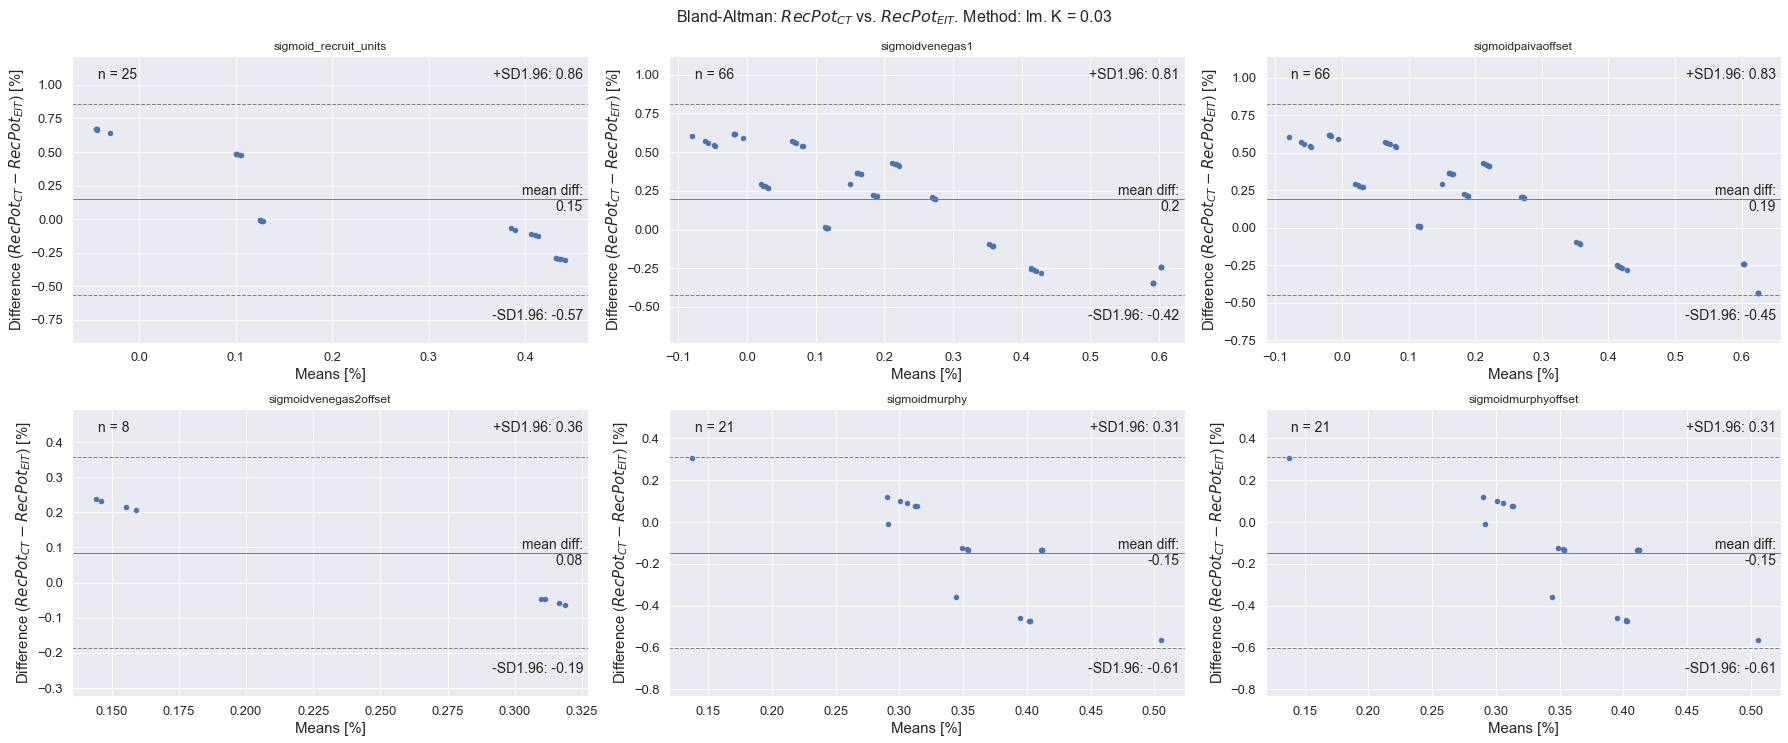

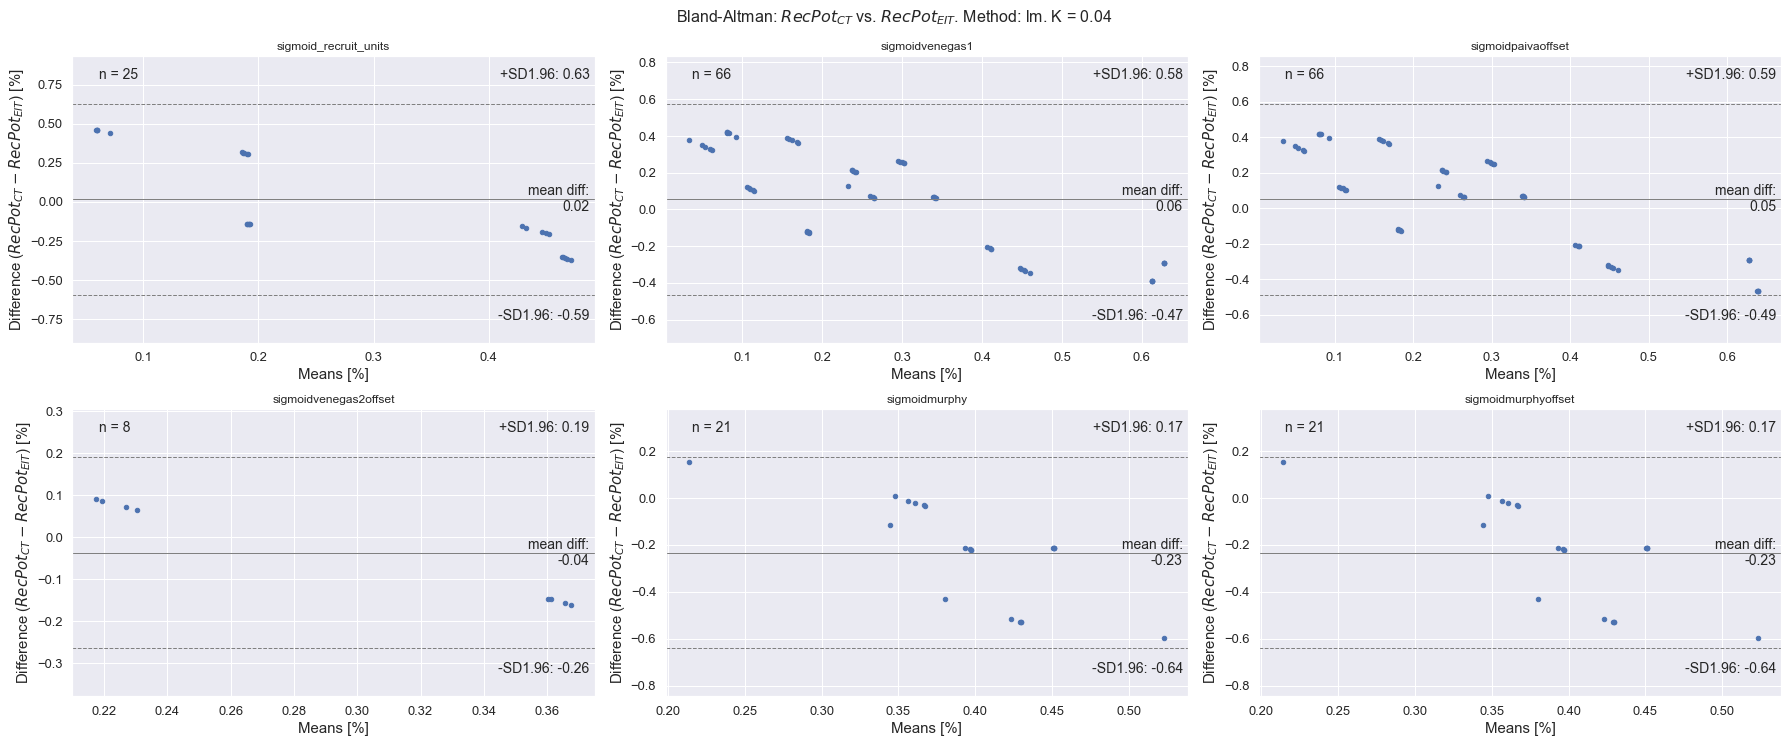

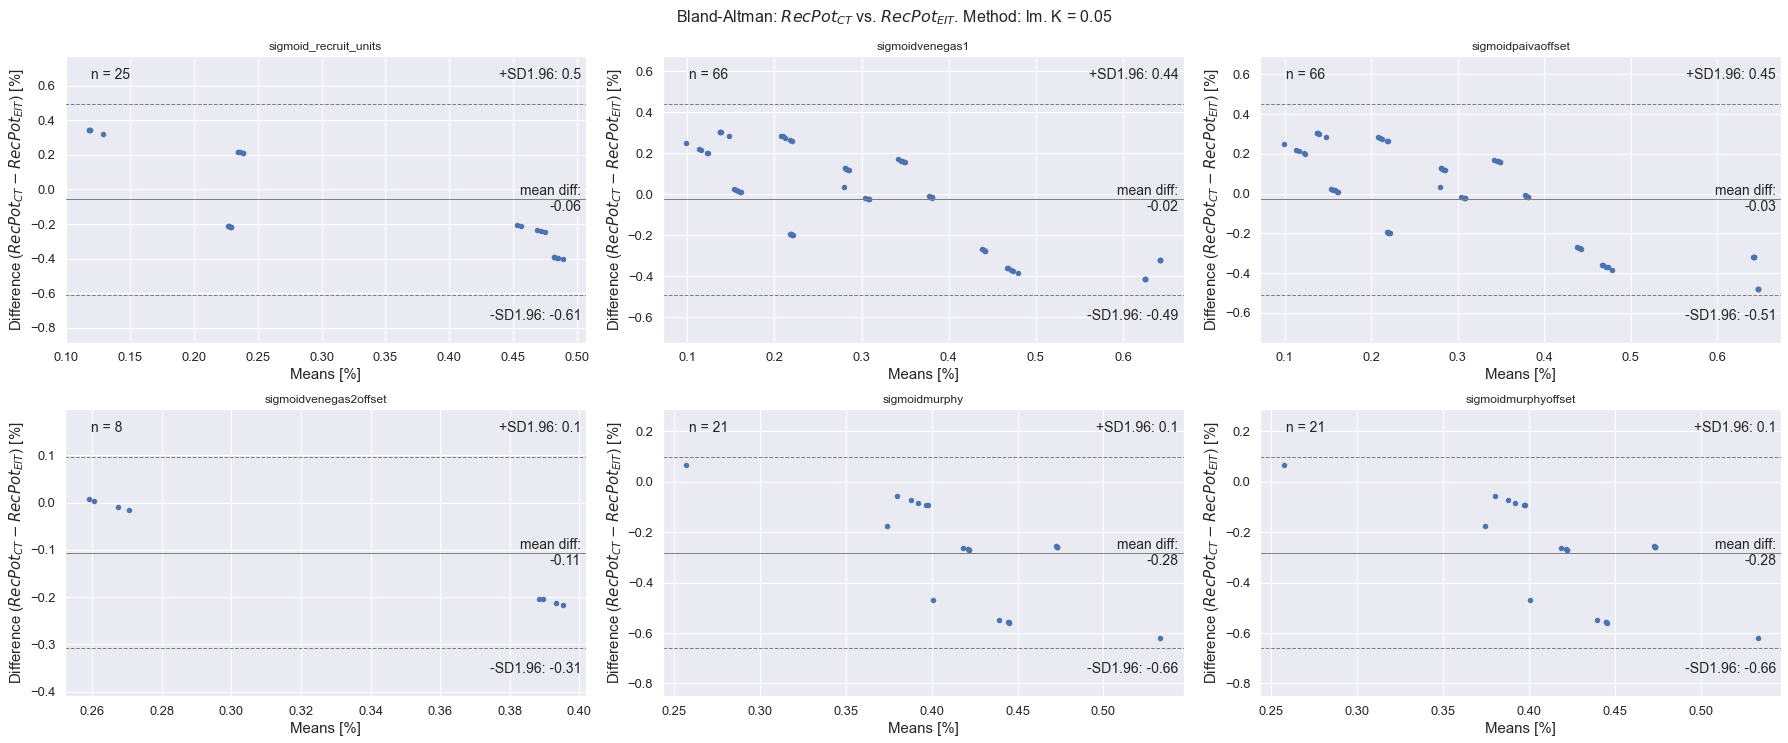

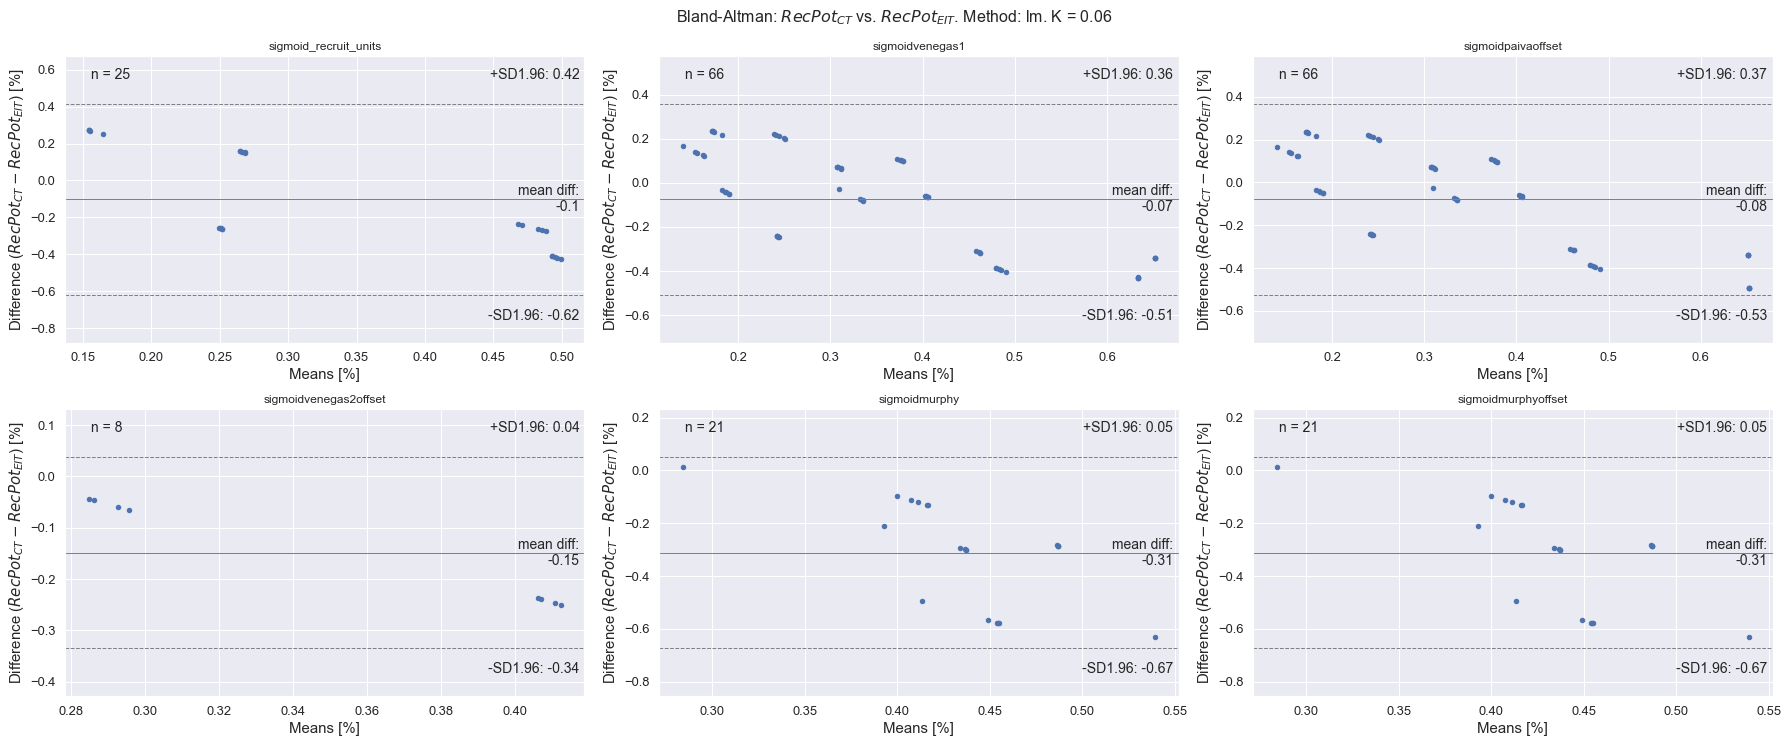

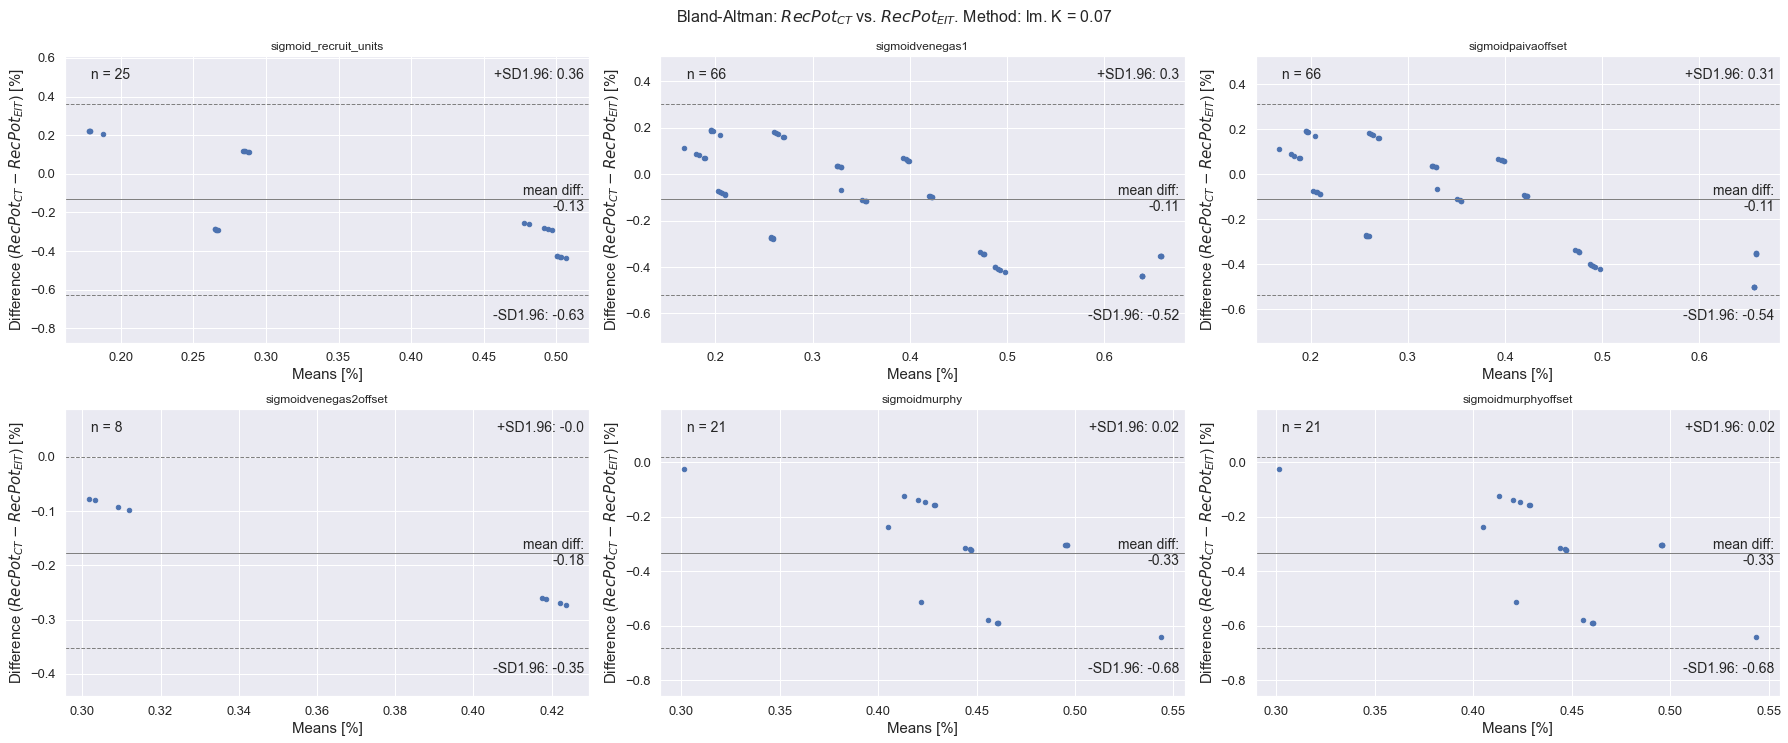

In [148]:
K_lst = [0.03, 0.04, 0.05, 0.06, 0.07]
for met in met_lst:
    for K1 in K_lst:
        f, ax = plt.subplots(2,3, figsize = (25,10))
        dados_ct_eit_fitted[['K1_eit','RecPotential_eit_K1','Recruited_eit_K1','RecPotential_error_K1' ]] = dados_ct_eit_fitted.apply(lambda x: estima_potencial(x, K=K1), axis=1, result_type='expand')
        for idx,model in enumerate(model_lst):
            cond = (dados_ct_eit_fitted['Model']==model)&\
                   (dados_ct_eit_fitted['fitted']==True)&\
                   (dados_ct_eit_fitted['Method']==met)
            if len(dados_ct_eit_fitted[cond]) > 0:
                sm.graphics.mean_diff_plot(dados_ct_eit_fitted[cond]['Recruitment potential'],dados_ct_eit_fitted[cond]['RecPotential_eit_K1'], ax = ax.ravel()[idx])
                ax.ravel()[idx].set_title(model)
                ax.ravel()[idx].set_xlabel('Means [%]')
                ax.ravel()[idx].set_ylabel('Difference ($RecPot_{CT} - RecPot_{EIT}$) [%]')
                xmin,xmax = ax.ravel()[idx].get_xlim()
                ymin,ymax = ax.ravel()[idx].get_ylim()
                ax.ravel()[idx].text(xmin+0.05*(xmax-xmin),ymin+0.92*(ymax-ymin),f'n = {len(dados_ct_eit_fitted[cond])}', fontsize=14)

        plt.suptitle('Bland-Altman: $RecPot_{CT}$ vs. $RecPot_{EIT}$. Method: ' + met + f'. K = {K1}', fontsize=16, y=1.03)
        plt.savefig(pasta_figuras_anexoE+f'BlandAltman_recpot_{met}_K{K1}.pdf',bbox_inches='tight')
        plt.show()